## **Stance Detection on Hansard Debate Corpus**<br/>
The project aims to detect the Stance(for/against) of the MP's speech with respect to a Motion. Please refer https://data.mendeley.com/datasets/xsvp45cbt4/2 and the corresponding paper to read details about each column of the dataset.


In [0]:
! pip install tensorflow==2.0.0
! pip install vaderSentiment

In [0]:
# import the required libraries
import re
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from tensorflow.keras.models import Model
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc, make_scorer, precision_score, recall_score, accuracy_score 
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Embedding, concatenate, Conv1D, MaxPooling1D, LSTM, Bidirectional, GRU, TimeDistributed, RepeatVector, Activation, Dot

nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings("ignore")
nltk.download('stopwords')
stopword = stopwords.words('english')

In [40]:
# read the data set as a dataframe
hansard = pd.read_csv('HanDeSeT.csv')
print('Dataset Size: ', hansard.shape)  # Data consists of only 1251 examples
hansard.head()

Dataset Size:  (1251, 16)


,id,title,motion,manual motion,govt/opp motion,motion party affiliation,utt1,utt2,utt3,utt4,utt5,manual speech,vote speech,party affiliation,name,rebellion %
0,1,Doctor Assisted Dying,That leave be given to bring in a Bill to enab...,1,1,Lab,I trust that the House will not feel that ther...,If one considers the argument from a religious...,I accept that we shall all face death at one t...,"When we listen to my hon. Friend's case, we mu...",I do not think that we want that sort of socie...,0,0,Lab,Kevin McNamara,3.2
1,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,The Secretary State talks of the lack of fuss ...,The right hon. Gentleman may not have heard fu...,North Tayside.,The Secretary of State's geography is terrible.,Would not the £40 million gap in the assumptio...,0,0,SNP,John Swinney,0.4
2,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,May I assure the right hon. Gentleman that he ...,Will the hon. Gentleman clarify what he meant ...,NaN,NaN,NaN,1,1,Lab,John McAllion,4.5
3,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,"Is the hon. Gentleman aware that, ever since t...","I rise as one who, in the past, has not been a...",It would be inappropriate to allow the debate ...,"Why are the problems of so many of our people,...",Today's debate is the first of this sort under...,0,1,Lab,Ian Davidson,3.1
4,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,The hon. Gentleman will notice that the Childr...,I thank the hon. Gentleman for his generosity ...,NaN,NaN,NaN,1,1,Lab,Maria Fyfe,2.3


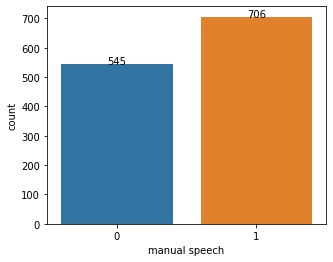

In [0]:
# Distribution of target (manual speech) variable
fig, ax = plt.subplots(figsize=(5,4))
graph = sns.countplot(x='manual speech', data=hansard)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

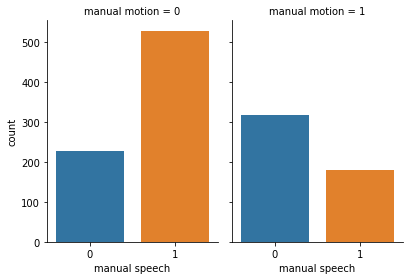

In [0]:
# Distribution of 'manual speech' (speech label) conditioned on 'manual motion' (motion label)
sns.catplot(x='manual speech', col='manual motion', data=hansard, kind="count", height=4, aspect=.7)

In [0]:
# Count of training examples in each of the four categories. As we can see, the dataset is imbalanced
hansard.groupby(['manual motion', 'manual speech']).size()

manual motion  manual speech
0              0                228
               1                527
1              0                317
               1                179
dtype: int64

#**Pre-processing data**

Pre-processing
1. Drop unused columns -> title, govt/oppo motion, vote speech, name, rebellion%. The paper published with regards to dataset specifies that manual labels are more accurate than division labels. So, we have only considered the manual label columns.
2. Combine 'utterances' columns to form a new 'speech' column
3. Remove proper nouns
4. Convert the text to lowercase
5. Remove punctuation, numbers, special characters
6. Remove removal_words list. We will use a manually defined list of words which contains articles, prepositions, 'months' and common words used in hansard speech like 'hon gentleman'. We are not using prefined stopwords lists from the python libraries because those lists contain words like 'not', 'dont', 'certainly' etc which are useful for stance prediction and should not be removed. Some words from the list are taken from this link and updated. https://gist.github.com/sebleier/554280
7. Remove bracketed text from Motion sentences.
8. Convert party labels to integers

Feature creation <br/>
(papers referred: https://www.aclweb.org/anthology/S17-2080.pdf, 
https://www.aclweb.org/anthology/W10-0214.pdf)
1. Find the Vader Sentiment compund score for motion and speech text
2. Count the number of question words in speech text (question words generally indicate arguments). We calculate count of question words only for speech text and not motion text as motions are plain sentences in the dataset.
3. Word Count of Speeches



In [41]:
motion_dict = {}

def clean_text(text, is_motion, motion_id):
  '''
  Input -> text: a string 
           is_motion: A boolean variable that specifies if the text is a motion or speech. If motion, an extra processing step of removing bracketed text is applied.
                      Motion text contains numbers and some extra information in brackets which is just plain text and does not express any emotion. 
                      So the bracketed text and numbers is removed.
           motion_id: ID of the motion (The motion column has repeated values identified by ids. The cleaned motion text is stored in a dictionary.
                      If the ID of the motion text to be processed is already present in the dictionary, then the value is returned. This saves processing time.)
  Returns -> cleaned_text
  '''
  removal_words = ["a", "am", "an", "and", "any","are", "as", "at", "ae", "by", "did", "from", "he", "her", "here", \
              "hers", "herself", "him", "himself", "his", "hon", "i", "in", "into", "is", "it", "it's", "its", \
              "itself", "ll", "m", "may", "me", "my", "myself", "now", "o", "of", "on", "once", "or", "other", "our", "ours", "ourselves", \
              "re", "s", "she", "she's", "so", "st", "such", "t", "th", "that", "that'll", "the", "their", "theirs", \
              "them", "themselves", "then", "there", "these", "they", "this", "those", "to", "ve", "was", \
              "we", "were", "with", "y", "you", "youd", "youll", "will", "government", "member",\
              "you're", "you've", "your", "yours", "yourself", "yourselves", "hed", "he'll", "hes", "heres", "hows", "i'd",\
              "i'll", "im", "ive", "lets", "she'd", "she'll", "thats", "there's", "theyd", "theyll", "theyre", "theyve", "we'd",\
              "we'll", "were", "weve", "gentleman", "friend", "house", "minister", "people", "january",\
              "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", "jan", "feb", "mar", \
              "apr", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

  # If the motion_id is present in the dictionary, then the motion is previously processed, so return the value
  if is_motion:
    if motion_id in motion_dict:
      return motion_dict[motion_id]

  # If not apply the processing steps for motion and speech
  cleaned_text = ' '.join([word for word, tag in pos_tag(text.split()) if tag != 'NNP' or tag != 'NNPS'])   # remove proper nouns
  cleaned_text = cleaned_text.lower()  # lowercasing

  # If the input sentence is a motion, remove bracketed text
  if is_motion:
    cleaned_text = re.sub("\(.*\)", "", cleaned_text) 

  cleaned_text = re.sub("[^a-zA-Z ]", "", cleaned_text) # remove punctation, numbers
  cleaned_text = ' '.join([word for word in cleaned_text.split() if (word not in removal_words) and len(word)>1]) # remove frequent words

  # cleaned motion text is stored in a dictionary
  if is_motion:
    motion_dict[motion_id] = cleaned_text
  return cleaned_text


def preprocess_data(df, augmented):
  '''
  Input -> df: Dataframe to be pre-processed
           augmented: boolean value which specifies if the dataframe is original or augmented. We have used data Augmentation is used to generate new text
                      Some preprocessing operations are to not be done on the augmented data frame. Thus, this argument helps to specify the condition.
  Returns -> Pre-processed DataFrame
  '''
  if not augmented:
    # Drop unused columns 
    df = df.drop(df.columns[[1, 4, 12, 14, 15]], axis=1)     

    # Since we are predicting sentiment(stance) given the motion statement, it is essential to include features from the motion text to identify whether the motion is positive or negative.
    # We will clean both motion and utterance text
    df['cleaned_motion'] = df.apply(lambda x: clean_text(x['motion'], True, x['id']), axis=1)
    
    # Cleaning utterances
    df['utt1'] = df['utt1'].apply(lambda x: clean_text(x, False, None) if (not pd.isna(x)) else '')
    df['utt2'] = df['utt2'].apply(lambda x: clean_text(x, False, None) if (not pd.isna(x)) else '')
    df['utt3'] = df['utt3'].apply(lambda x: clean_text(x, False, None) if (not pd.isna(x)) else '')
    df['utt4'] = df['utt4'].apply(lambda x: clean_text(x, False, None) if (not pd.isna(x)) else '')
    df['utt5'] = df['utt5'].apply(lambda x: clean_text(x, False, None) if (not pd.isna(x)) else '')

    # drop motion column
    df = df.drop(['motion'], axis=1) 

    # Combine the Utterances and create a new column named 'speech' 
    cols = ['utt1', 'utt2', 'utt3', 'utt4', 'utt5']
    df["cleaned_speech"] = df[cols].apply(lambda x: ' '.join(x.dropna()), axis=1)

    # Let us convert the party labels to integer 
    motion_party = {'Lab': 1, 'Con': 2, 'SNP': 3, 'DUP': 4, 'LD':5}
    party = {'Lab': 1, 'Con': 2, 'SNP': 3, 'DUP': 4, 'LD':5, 'SDLP': 6, 'IndUU': 6, 'UUP': 6, 'IndSN': 6, 'Green': 6, 'PC': 6, 'IndCon': 6, 'IndLab': 6}

    df['motion party affiliation'] = df['motion party affiliation'].apply(lambda x: motion_party[x])
    df['party affiliation'] = df['party affiliation'].apply(lambda x: party[x])

  # New feature creation
  # 1. question word count
  df['speech_ques_words'] = df['cleaned_speech'].str.count(r'(what)|(when)|(where)|(which)|(who)|(whom)|(why)|(whose)|(how)')

  # 2. vader sentiment compund score
  analyser = SentimentIntensityAnalyzer()
  df['motion_score'] = df['cleaned_motion'].apply(lambda x: (analyser.polarity_scores(x))['compound'])
  df['speech_score'] = df['cleaned_speech'].apply(lambda x: (analyser.polarity_scores(x))['compound'])

  # 3. speech word count
  df['speech_word_count'] = df['cleaned_speech'].apply(lambda x: len([w for w in x.split()]))

  return df

hansard = preprocess_data(hansard, False)
print(hansard.shape)
hansard.head()
  

(1251, 16)


,id,manual motion,motion party affiliation,utt1,utt2,utt3,utt4,utt5,manual speech,party affiliation,cleaned_motion,cleaned_speech,speech_ques_words,motion_score,speech_score,speech_word_count
0,1,1,1,trust not feel lack compassion side argument a...,if one considers argument religious point view...,accept shall all face death one time another b...,when listen friends case must put aside religi...,do not think want sort society denial human di...,0,1,leave be given bring bill enable person who su...,trust not feel lack compassion side argument a...,14,-0.8555,-0.9987,355
1,2,1,1,secretary state talks lack fuss about local se...,right not have heard fully what said motion wh...,north tayside,secretary states geography terrible,would not million gap assumptions be tackled i...,0,3,local finance order dated copy which laid befo...,secretary state talks lack fuss about local se...,4,0.4215,-0.0900,117
2,2,1,1,assure right probably alone thinking sad matte...,clarify what meant disgraceful smear against l...,,,,1,1,local finance order dated copy which laid befo...,assure right probably alone thinking sad matte...,4,0.4215,-0.7269,59
3,2,1,1,aware ever since beginning urban aid programme...,rise one who past has not been great enthusias...,would be inappropriate allow debate pass witho...,why problems many who have live rented housing...,todays debate first sort under labour lack adv...,0,1,local finance order dated copy which laid befo...,aware ever since beginning urban aid programme...,10,0.4215,0.9781,289
4,2,1,1,notice children scotland act enacted has been ...,thank for generosity giving way again doing wh...,,,,1,1,local finance order dated copy which laid befo...,notice children scotland act enacted has been ...,2,0.4215,0.6748,111


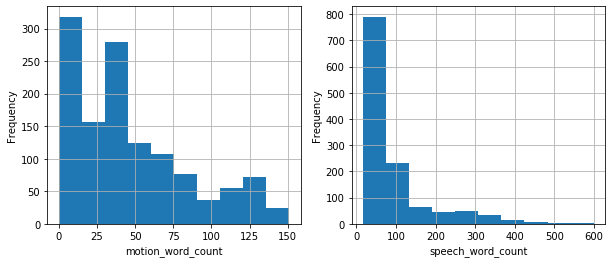

In [0]:
# Distribution of word counts in motion and speech text after preprocessing
motion_word_count = hansard['cleaned_motion'].apply(lambda x: len([w for w in x.split()]))
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
motion_word_count.hist(ax=axes[0])
hansard['speech_word_count'].hist(ax=axes[1])
x_labels = ['motion_word_count', 'speech_word_count']
i = 0
for ax in axes:
  ax.yaxis.grid(True)
  ax.set_xlabel(x_labels[i])
  ax.set_ylabel('Frequency')
  i = i + 1

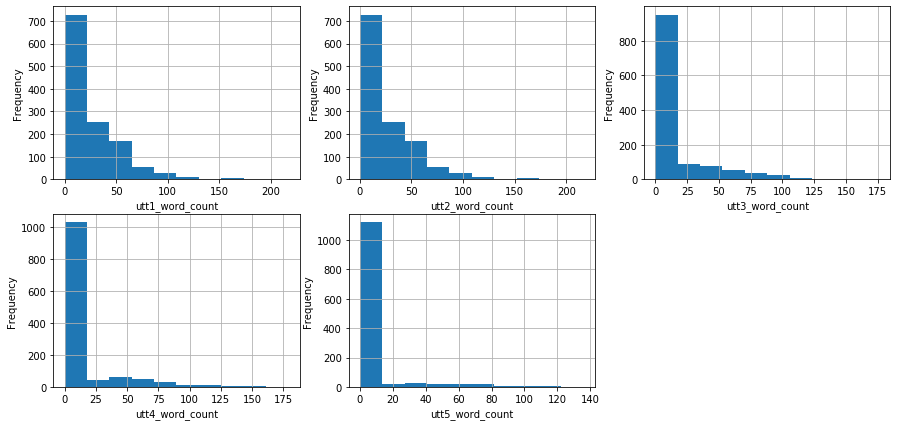

In [0]:
# Distribution of number of utterances per motion
utt1_word_count = hansard['utt1'].apply(lambda x: len([w for w in x.split()]))
utt2_word_count = hansard['utt2'].apply(lambda x: len([w for w in x.split()]))
utt3_word_count = hansard['utt3'].apply(lambda x: len([w for w in x.split()]))
utt4_word_count = hansard['utt4'].apply(lambda x: len([w for w in x.split()]))
utt5_word_count = hansard['utt5'].apply(lambda x: len([w for w in x.split()]))

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
utt2_word_count.hist(ax=axes[0, 0])
utt2_word_count.hist(ax=axes[0, 1])
utt3_word_count.hist(ax=axes[0, 2])
utt4_word_count.hist(ax=axes[1, 0])
utt5_word_count.hist(ax=axes[1, 1])
x_labels = ['utt1_word_count', 'utt2_word_count', 'utt3_word_count', 'utt4_word_count', 'utt5_word_count']
i = 0
fig.delaxes(axes[1, 2])
axes = axes.flatten()
for ax in axes:
  if i == 5:
    break
  ax.yaxis.grid(True)
  ax.set_xlabel(x_labels[i])
  ax.set_ylabel('Frequency')
  i = i + 1

As can be seen the graphs are highly skewed. During tokenization/padding, we will keep the maximum length for speeches as 400, Utterances as 100 (utterances are used in the last nn model) and motion text will not be truncated.

# **Classification Models and Feature selection**
We will build the following models
1. Support Vector Machines
2. Neural Netowrks

We will analyze the prediction accuracy of models using following features
1. Text data will be converted to following representations - token combination of 1,2,3 grams
   1. Bag of Words (SVMs)
   2. TF-IDF (SVMs, Neural Networks)
   3. Glove (Neural Networks)

2. Extra available features along with Speech column. 
   The features are (References: https://www.aclweb.org/anthology/L18-1659.pdf)
   1. Debate id -> . As there are usually multiple speeches in each debate, and MPs will often express similar sentiments to members of their own party in a particular debate, we also follow Salah (2014) in including this feature to capture possible correlations between MPs’ speech and voting behaviour.
   2. Speaker party affiliation -> Intuition suggests
that a speaker’s party membership should be
a strong indicator of sentiment towards many
topics, and Salah (2014) showed this to be the
case, at least as far as correlation with speakers’ division vote goes
   3. Motion party affiliation. Because MPs are
likely to be more or less supportive of a motion depending on who proposes it, we add that Member’s party as a further contextual feature.
   4. Manual Motion - label indicating if the motion is positive or negative

3. Newly created features
  1. Vader sentiment score
  2. Count of question words
  3. Count of words in speech text
 

   Papers and websites referred
1. https://www.aclweb.org/anthology/L18-1659.pdf
2. https://arxiv.org/pdf/1510.03820.pdf
3. https://www.aclweb.org/anthology/W10-0214.pdf
4. https://www.aclweb.org/anthology/C18-1203.pdf
5. https://machinelearningmastery.com
6. http://www.davidsbatista.net/blog/2018/03/31/SentenceClassificationConvNets/
    

Let us draw WordClouds and find the frequest words in positive and negative speeches

In [0]:
# Method to generate word clouds
def create_wordcloud(label):
  # combine all the tweets and build a wordCloud for 'Labour' party
  text = ' '.join([sent for sent in hansard['cleaned_speech'][hansard['manual speech'] == label]])
  wordcloud = WordCloud(width=400, height=300, random_state=21, max_font_size=110).generate(text)
  plt.figure(figsize=(10, 7)) 
  plt.imshow(wordcloud, interpolation="bilinear") 
  plt.axis('off')


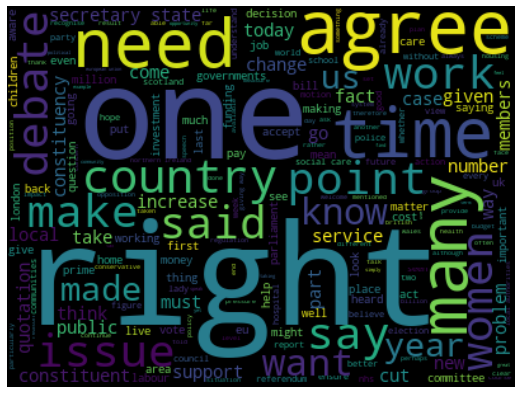

In [0]:
create_wordcloud(1)

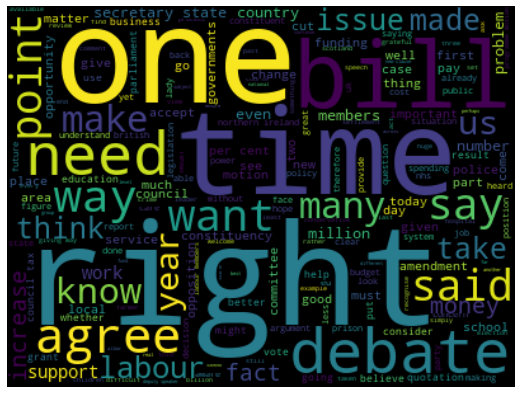

In [0]:
create_wordcloud(0)

As we can see, we cannot infer about positive or negative speeches from the words clouds because both use similar set of frequent words. 
Now, we will split the data into 90% train and 10% test set

In [0]:
x_train, x_test, y_train, y_test = train_test_split(hansard, hansard['manual speech'], test_size=0.1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1125, 16)
(1125,)
(126, 16)
(126,)


Let's create Bag Of Words and TF-IDF features

In [0]:
# Method to create a new matrix with added features
def add_feature(X, Y, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    return hstack([X, Y, csr_matrix(feature_to_add).T], 'csr')

# Method to convert text using CountVectorizer
def generate_bow_val(x_train, x_test):
  bow_vectorizer_motion = CountVectorizer(max_df=0.85, min_df=2, ngram_range=(1,3))
  bow_vectorizer_speech = CountVectorizer(max_df=0.90, min_df=5, ngram_range=(1,3)) 
  bow_motion = bow_vectorizer_motion.fit_transform(x_train['cleaned_motion']) 
  bow_motion_test = bow_vectorizer_motion.transform(x_test['cleaned_motion'])
  bow_speech = bow_vectorizer_speech.fit_transform(x_train['cleaned_speech']) 
  bow_speech_test = bow_vectorizer_speech.transform(x_test['cleaned_speech'])
  return bow_motion, bow_motion_test, bow_speech, bow_speech_test

# Method to convert text using TfidfVectorizer
def generate_tfidf_val(x_train, x_test):
  tfidf_vectorizer_motion = TfidfVectorizer(max_df=0.85, min_df=2, ngram_range=(1,3))
  tfidf_vectorizer_speech = TfidfVectorizer(max_df=0.90, min_df=5, ngram_range=(1,3)) 
  tfidf_motion = tfidf_vectorizer_motion.fit_transform(x_train['cleaned_motion']) 
  tfidf_motion_test = tfidf_vectorizer_motion.transform(x_test['cleaned_motion'])
  tfidf_speech = tfidf_vectorizer_speech.fit_transform(x_train['cleaned_speech']) 
  tfidf_speech_test = tfidf_vectorizer_speech.transform(x_test['cleaned_speech'])
  return tfidf_motion, tfidf_motion_test, tfidf_speech, tfidf_speech_test

# Method to generate ROC-AUC Curve
def plot_roc_curve(fpr, tpr):
  lw = 2
  area = auc(fpr, tpr)
  plt.figure(figsize=(6, 5)) 
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % area)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

# Below methods are used to fit Support Vector Classifiers and perform cross-validation
# Method instantiates a SVC on training data and performs cross-validation to find the best regularization parameter
def find_best_reg(inverse_lambda, train_data, train_labels):
  mean_scores = []
  for reg in inverse_lambda:
    svm = SVC(C=reg, gamma='scale')
    all_scores = cross_val_score(svm, train_data, train_labels, cv=5, scoring='f1')
    mean_scores.append(all_scores.mean())
  return mean_scores

# Method uses the best parameter 'C' to predict labels on test data
def svm_predict(reg, train_data, train_labels, test_data):
  final_svm = SVC(C=reg, gamma='scale')
  final_svm.fit(train_data, train_labels)
  y_pred_svm = final_svm.predict(test_data)
  return y_pred_svm

In [0]:
# generate BOW features
bow_motion, bow_motion_test, bow_speech, bow_speech_test = generate_bow_val(x_train, x_test)
# generate tfidf features
tfidf_motion, tfidf_motion_test, tfidf_speech, tfidf_speech_test = generate_tfidf_val(x_train, x_test)

# Create the final feature matrix by adding extra features
bow = add_feature(bow_motion, bow_speech, [x_train['id'], x_train['motion party affiliation'], x_train['manual motion'], x_train['party affiliation'], x_train['speech_ques_words'], x_train['motion_score'],	x_train['speech_score'], x_train['speech_word_count']])
bow_test = add_feature(bow_motion_test, bow_speech_test, [x_test['id'], x_test['motion party affiliation'], x_test['manual motion'], x_test['party affiliation'], x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'], x_test['speech_word_count']])
tfidf = add_feature(tfidf_motion, tfidf_speech, [x_train['id'], x_train['motion party affiliation'], x_train['manual motion'], x_train['party affiliation'], x_train['speech_ques_words'], x_train['motion_score'],	x_train['speech_score'], x_train['speech_word_count']])
tfidf_test = add_feature(tfidf_motion_test, tfidf_speech_test, [x_test['id'], x_test['motion party affiliation'], x_test['manual motion'], x_test['party affiliation'], x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'],  x_test['speech_word_count']])

print('BOW train matrix shape: ', bow.shape)
print('BOW test matrix shape: ', bow_test.shape)
print('TF-IDF train matrix shape: ', tfidf.shape)
print('TF-IDF test matrix shape: ', tfidf_test.shape)

BOW train matrix shape:  (1125, 13935)
BOW test matrix shape:  (126, 13935)
TF-IDF train matrix shape:  (1125, 13935)
TF-IDF test matrix shape:  (126, 13935)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
**Support Vector Machines using BOW and TF-IDF features for Text**<br/>
We are using cross-validation to find the best regularization value.

*Support Vector Classifier using BOW features*

Mean Scores:  [0.7244881534895699, 0.7244881534895699, 0.7187213494720577, 0.7287558946789343, 0.7404202862869108, 0.7356831208736685, 0.7402806557637913, 0.7395268453991954, 0.7416039197310474, 0.7406990785142786, 0.7406876841161754, 0.7443870950464124, 0.735971663293792, 0.7354402805670704, 0.7322839152931495]


Text(0, 0.5, 'Mean Scores')

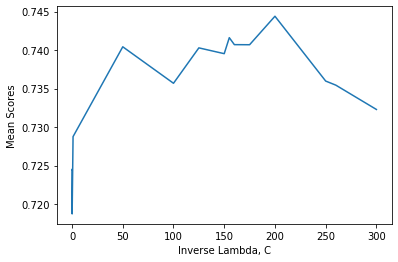

In [0]:
# Cross validate the model using a set of 'C' values
inverse_lambda = [0.001, 0.01, 0.1, 1, 50, 100, 125, 150, 155, 160, 175, 200, 250, 260, 300]
mean_scores = find_best_reg(inverse_lambda, bow, y_train)
print('Mean Scores: ', mean_scores)
plt.plot(inverse_lambda, mean_scores)
plt.xlabel('Inverse Lambda, C')
plt.ylabel('Mean Scores')

Confusion Matrix:
 [[34 25]
 [12 55]]
F1-score:  0.7482993197278912
ROC_AUC_score:  0.6985833544143689


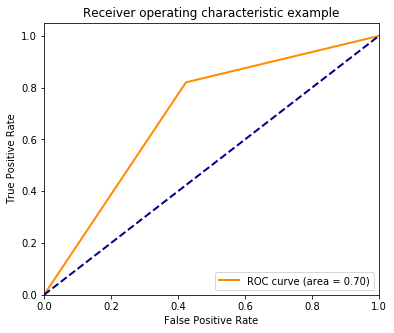

In [0]:
# Refit the model using the best 'C' (highest mean score)
y_pred_svm = svm_predict(200, bow, y_train, bow_test)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_svm))
print('F1-score: ', f1_score(y_test, y_pred_svm))
print('ROC_AUC_score: ', roc_auc_score(y_test, y_pred_svm))
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
plot_roc_curve(fpr, tpr)

--------------------------------------------------------------------------------
*Support Vector Classifier using TF-IDF features*

Mean Scores:  [0.7201701731593002, 0.750476363588277, 0.7602880203061612, 0.7607815062756791, 0.7590213497562057, 0.7562916835325141, 0.7625017854445765, 0.7638614058822071, 0.7692381848102834, 0.7648549494798709, 0.7632722652479267, 0.7590917435887412]


Text(0, 0.5, 'Mean Scores')

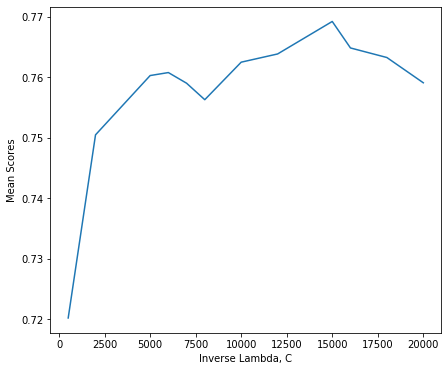

In [0]:
inverse_lambda = [500, 2000, 5000, 6000, 7000, 8000, 10000, 12000, 15000, 16000, 18000, 20000]
mean_scores = find_best_reg(inverse_lambda, tfidf, y_train)
print('Mean Scores: ', mean_scores)
plt.figure(figsize=(7, 6)) 
plt.plot(inverse_lambda, mean_scores)
plt.xlabel('Inverse Lambda, C')
plt.ylabel('Mean Scores')

Confusion Matrix:
 [[35 24]
 [10 57]]
F1-score:  0.7702702702702703
ROC_AUC_score:  0.7219833038198836


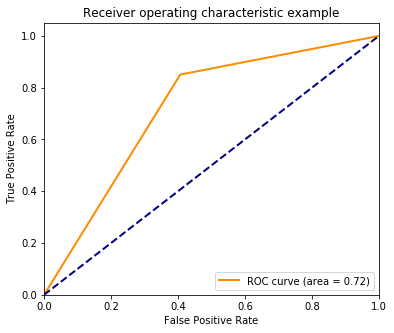

In [0]:
# Refit the model using best 'C'
y_pred_svm = svm_predict(15000, tfidf, y_train, tfidf_test)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_svm))
print('F1-score: ', f1_score(y_test, y_pred_svm))
print('ROC_AUC_score: ', roc_auc_score(y_test, y_pred_svm))
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
plot_roc_curve(fpr, tpr)

*As can be seen, TFIDF features provide improved score compared to BOW features*

In [0]:
del bow, bow_motion, bow_speech, bow_speech_test, bow_test, bow_motion_test
del tfidf_motion, tfidf_speech, tfidf_motion_test, tfidf_speech_test

---------------------------------------------------------------------------------------------------------------------------------------------------------------<br/>**1. Single Channel Fully Connected Neural Network**<br/> 
Let us build a simple MLP model to predict the stance. We use the tfidf text feature matrix along with the other feature columns. We use Grid Search to find the right number of hidden neurons which give the best AUC. We check the AUC as the metric since we hava an imbalanced dataset. 

In [0]:
# First neural network model with one hidden layer and Dropout/Batchnormalization
def nn_model_1(num_neurons):
  model = tf.keras.Sequential([
          tf.keras.layers.Dense(num_neurons, activation='relu',  kernel_initializer='he_normal'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dense(num_neurons, activation='relu', kernel_initializer='he_normal'),        
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)  
  return model

In [0]:
# Perform Grid search to find best hyper-parameters
model_CV = KerasClassifier(build_fn=nn_model_1, epochs=200, batch_size=250, verbose=0)

# define the grid search parameters
num_neurons = [50, 75, 100, 120, 150, 200, 250]

# Evaluation Metrics
scores = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'auc':make_scorer(roc_auc_score)
}

param_grid = dict(num_neurons=num_neurons)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=4, refit='auc' , scoring = scores)
grid_result = grid.fit(tfidf.toarray(), y_train, verbose=0)


In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_auc']
stds = grid_result.cv_results_['std_test_auc']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.691436 using {'num_neurons': 50}
0.691436 (0.034652) with: {'num_neurons': 50}
0.667613 (0.024156) with: {'num_neurons': 75}
0.663848 (0.010741) with: {'num_neurons': 100}
0.674797 (0.025895) with: {'num_neurons': 120}
0.688156 (0.028666) with: {'num_neurons': 150}
0.679522 (0.023577) with: {'num_neurons': 200}
0.670310 (0.017489) with: {'num_neurons': 250}


Confusion Matrix:
 [[31 18]
 [16 61]]
F1-score:  0.7820512820512822
ROC_AUC_score:  0.7124304267161411


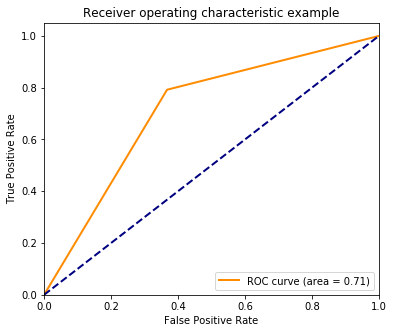

In [0]:
# Use the best grid search result to predict score on test data
y_pred = grid_result.predict(tfidf_test.toarray())
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('F1-score: ', f1_score(y_test, y_pred))
print('ROC_AUC_score: ', roc_auc_score(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_pred)
plot_roc_curve(fpr, tpr)

*But the simple nn score is similar to SVM score and there is not much improvement*

--------------------------------------------------------------------------------
**2. Multi-Channel Neual Network with LSTM**<br/>
The NN consists of two channels. 
1. The first channel takes combined motion and speech text as input and uses a LSTM to learn weights
2. The second channel takes the additional features and uses a fully connected dense layer to learn weights

In [0]:
# Prepare and reshape the data to feed to the network
def reshape_data_lstm(x_train, x_test, y_test, tfidf_motion, tfidf_speech):
  xtrain = hstack([tfidf_motion, tfidf_speech], 'csr')
  xtest = hstack([tfidf_motion_test, tfidf_speech_test], 'csr')
  
  # create a validation set for tfidf features
  xtrain, xval, ytrain, yval = train_test_split(xtrain, x_train['manual speech'], test_size=0.1, random_state=42)
  ytrain = np.array(ytrain)
  ytest = np.array(y_test)
  yval = np.array(yval)

  xtrain2 = add_feature(None, None, [x_train['id'], x_train['motion party affiliation'], x_train['party affiliation'], x_train['manual motion'], x_train['speech_ques_words'], x_train['motion_score'], x_train['speech_score'], x_train['speech_word_count']])
  xtrain2, xval2, _, _ = train_test_split(xtrain2, x_train['manual speech'], test_size=0.1, random_state=42)
  xtest2 = add_feature( None, None, [x_test['id'], x_test['motion party affiliation'], x_test['party affiliation'], x_test['manual motion'],x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'], x_test['speech_word_count']])

  # reshape data to feed into LSTM (batch_size, timesteps, no_of_features)
  xtrain = xtrain.toarray()
  xval = xval.toarray()
  xtest = xtest.toarray()
  xtrain = xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1])
  xval = xval.reshape(xval.shape[0], 1, xval.shape[1])
  xtest = xtest.reshape(xtest.shape[0], 1, xtest.shape[1])
  ytrain = ytrain.reshape(ytrain.shape[0], 1)
  yval = yval.reshape(yval.shape[0], 1)
  ytest = ytest.reshape(ytest.shape[0], 1)

  return xtrain, xval, xtest, xtrain2, xval2, xtest2, ytrain, yval, ytest

# Mutli-channel nn model
def nn_model_2(n_neurons, length2, metrics):
  # channel 1 for text data consists of a LSTM
  inputs1 = Input(shape=(1, xtrain.shape[2]))
  lstm1 = LSTM(25, input_shape=(1, xtrain.shape[2]), recurrent_dropout=0.7)(inputs1)
  drop1 = Dropout(rate=0.7)(lstm1)
  flat1 = Flatten()(drop1)
  dense1 = Dense(16, activation='relu', kernel_initializer="he_normal")(flat1)

  # channel 2 for the numeric features uses a fully connected dense layer
  inputs2 = Input(shape=(length2,))
  dense2 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs2)
  drop2 = Dropout(rate=0.7)(dense2)
  bn2 = BatchNormalization()(drop2)

  # merge
  merged = concatenate([dense1, bn2])

  # shared by both channel outputs
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(merged)
  drop3 = Dropout(rate=0.5)(dense3)
  bn3 = BatchNormalization()(drop3)
  outputs = Dense(1, activation='sigmoid')(bn3)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
  return model

# Plots the graphs of different metrics vs epochs
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = (12, 10)
def plot_metrics(history):
  metrics =  ['loss', 'accuracy','auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

In [0]:
xtrain, xval, xtest, xtrain2, xval2, xtest2, ytrain, yval, ytest = reshape_data_lstm(x_train, x_test, y_test, tfidf_motion, tfidf_speech)
print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)
print(xtest.shape)
print(ytest.shape)

(1012, 1, 13927)
(1012, 1)
(113, 1, 13927)
(113, 1)
(126, 1, 13927)
(126, 1)


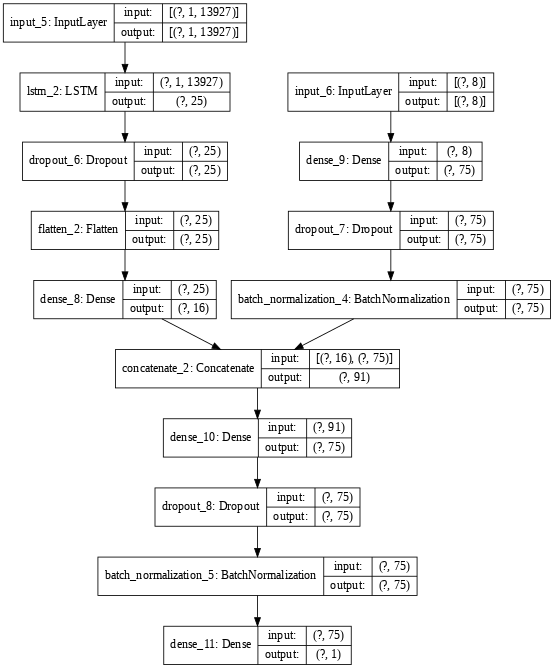

In [0]:
# Define the evaluation metrics
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
# create checkpoint to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model1.hdf5', monitor='auc', verbose=0, save_best_only=True, mode='max')
# Use early stopping to stop the training if there is no improvement in validation loss
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='min')
# instantiate the model
model = nn_model_2(75, xtrain2.shape[1], metrics)
# plot the model with shapes
plot_model(model, to_file='model1.png', show_shapes=True, dpi=60)

In [0]:
# use the model to fit the data
history = model.fit([xtrain, xtrain2.toarray()], ytrain, epochs=50, batch_size=300, validation_data=([xval, xval2.toarray()], yval), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)

Train on 1012 samples, validate on 113 samples
Epoch 1/50
1012/1012 [==============================] - 4s 4ms/sample - loss: 0.8429 - accuracy: 0.5445 - precision: 0.6092 - recall: 0.5133 - auc: 0.5452 - val_loss: 0.8741 - val_accuracy: 0.5752 - val_precision: 0.7500 - val_recall: 0.4714 - val_auc: 0.5462
Epoch 2/50
1012/1012 [==============================] - 0s 286us/sample - loss: 0.8226 - accuracy: 0.5287 - precision: 0.5902 - recall: 0.5097 - auc: 0.5384 - val_loss: 0.7900 - val_accuracy: 0.5752 - val_precision: 0.7500 - val_recall: 0.4714 - val_auc: 0.5400
Epoch 3/50
1012/1012 [==============================] - 0s 278us/sample - loss: 0.8482 - accuracy: 0.5119 - precision: 0.5714 - recall: 0.5027 - auc: 0.5096 - val_loss: 0.7655 - val_accuracy: 0.5841 - val_precision: 0.7556 - val_recall: 0.4857 - val_auc: 0.5415
Epoch 4/50
1012/1012 [==============================] - 0s 279us/sample - loss: 0.8385 - accuracy: 0.5237 - precision: 0.5790 - recall: 0.5381 - auc: 0.5254 - val_loss: 

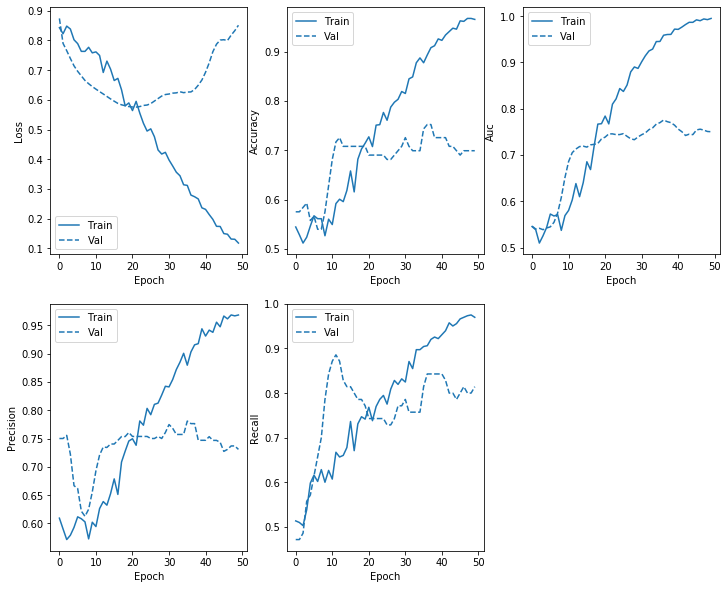

In [0]:
plot_metrics(history)

We tuned the model for several different value of hyperparameters (hidden units for Dense and LSTM layers) but the validation auc did not increase beyond 0.77

In [0]:
# Evaluate the score of the best model on test set
model.load_weights("best_model1.hdf5")
results = model.evaluate([xtest, xtest2.toarray()], ytest, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()


loss :  0.9137467883882069
accuracy :  0.7063492
precision :  0.71794873
recall :  0.7887324
auc :  0.75889885



*Using an LSTM, improved the score.*

----------------------------------------------------------------------------------------------------------------------------------------------------------------
**3. Embeddingds + LSTM**<br/>
Let us find whether the score improves if we use word embeddings instead of tfidf features. We will test the model using pretrained Glove word embeddings of 100 dimension. We will also feed and train motion and speech text as separate channels

In [0]:
# Method to tokenize and pad sentences
def create_embedding_text(tokenizer, train, val, test, max_length):
  if max_length is None:
    max_length = max([len(sent.split()) for sent in train])
  train_sequences = tokenizer.texts_to_sequences(train)
  train_padded = pad_sequences(train_sequences, padding='pre', maxlen=max_length, truncating='pre')
  validation_sequences = tokenizer.texts_to_sequences(val)
  validation_padded = pad_sequences(validation_sequences, padding='pre', maxlen=max_length, truncating='pre')
  test_sequences = tokenizer.texts_to_sequences(test)
  test_padded = pad_sequences(test_sequences, padding='pre', maxlen=max_length, truncating='pre')
  return (train_padded, validation_padded, test_padded, max_length)


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Split the data into validation set (10%)
x_old = x_train
x_train, x_val, y_train, y_val = train_test_split(x_train, x_train['manual speech'], test_size=0.1)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# Preparing text for Embedding layer
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(x_old['cleaned_motion'] + x_old['cleaned_speech'])
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

Xtrain1, Xval1, Xtest1, length1 = create_embedding_text(tokenizer, x_train['cleaned_motion'], x_val['cleaned_motion'], x_test['cleaned_motion'], None)
Xtrain2, Xval2, Xtest2, length2 = create_embedding_text(tokenizer, x_train['cleaned_speech'], x_val['cleaned_speech'], x_test['cleaned_speech'], 400)
Xtrain3 = add_feature(None, None, [x_train['id'], x_train['motion party affiliation'], x_train['party affiliation'], x_train['manual motion'], x_train['speech_ques_words'], x_train['motion_score'], x_train['speech_score'], x_train['speech_word_count']])
Xval3 = add_feature(None, None, [x_val['id'], x_val['motion party affiliation'], x_val['party affiliation'], x_val['manual motion'], x_val['speech_ques_words'], x_val['motion_score'], x_val['speech_score'], x_val['speech_word_count']])
Xtest3 = add_feature( None, None, [x_test['id'], x_test['motion party affiliation'], x_test['party affiliation'], x_test['manual motion'],x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'], x_test['speech_word_count']])
length3 = Xtrain3.shape[1]



In [0]:
# load the Glove embeddings
EMBEDDING_DIM = 100
embeddings_index = {}
f = open(r'/content/gdrive/My Drive/glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = ''.join(values[:-100])
    coefs = np.array(values[-100:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Create the embedding matrix
def create_embedding_matrix(word_index, EMBEDDING_DIM, embeddings_index):
  embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector 
  return embedding_matrix


In [0]:
# Form embedding matrix
embedding_matrix = create_embedding_matrix(word_index, EMBEDDING_DIM, embeddings_index)
# create the respective embedding matrices for motion and speech text
embedding_motion = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=length1, trainable=False)
embedding_speech = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=length2, trainable=False)

In [0]:
# NN model with embeddings and LSTM (Multichannel)
def nn_model_3(n_neurons, h1, h2, length1, length2, length3, vocab_size, metrics, embedding_motion, embedding_speech, pretrained):
  # channel 1 for motion text
  # If pretrained variable is True, train the model using pretrained Glove embedding matrix
  # Else feed the input data into an Embedding layer to train new embeddings for the model
  inputs1 = Input(shape=(length1,))
  embedding1=None
  if pretrained:
    embedding1 = embedding_motion(inputs1)
  else:
    embedding1 = Embedding(vocab_size, 100)(inputs1)
  lstm1 = LSTM(h1, recurrent_dropout=0.7)(embedding1)
  drop1 = Dropout(rate=0.5)(lstm1)
  flat1 = Flatten()(drop1)
  dense1 = Dense(1, activation='relu')(flat1)

  # channel 2 for speech text
  inputs2 = Input(shape=(length2,))
  embedding2=None
  if pretrained:
    embedding2 = embedding_motion(inputs2)
  else:
    embedding2 = Embedding(vocab_size, 100)(inputs2)
  lstm2 = LSTM(h2, recurrent_dropout=0.7)(embedding2)
  drop2 = Dropout(rate=0.5)(lstm2)
  flat2 = Flatten()(drop2)
  dense2 = Dense(1, activation='relu')(flat2)

  # channel 3 for numeric features
  inputs3 = Input(shape=(length3,))
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs3)
  drop3 = Dropout(rate=0.7)(dense3)
  bn3 = BatchNormalization()(drop3)

  # merge the outputs of three channels
  merged = concatenate([dense1, dense2, bn3])

  # shared
  dense4 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(merged)
  drop4 = Dropout(rate=0.5)(dense4)
  bn4 = BatchNormalization()(drop4)
  outputs = Dense(1, activation='sigmoid')(bn4)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
  return model



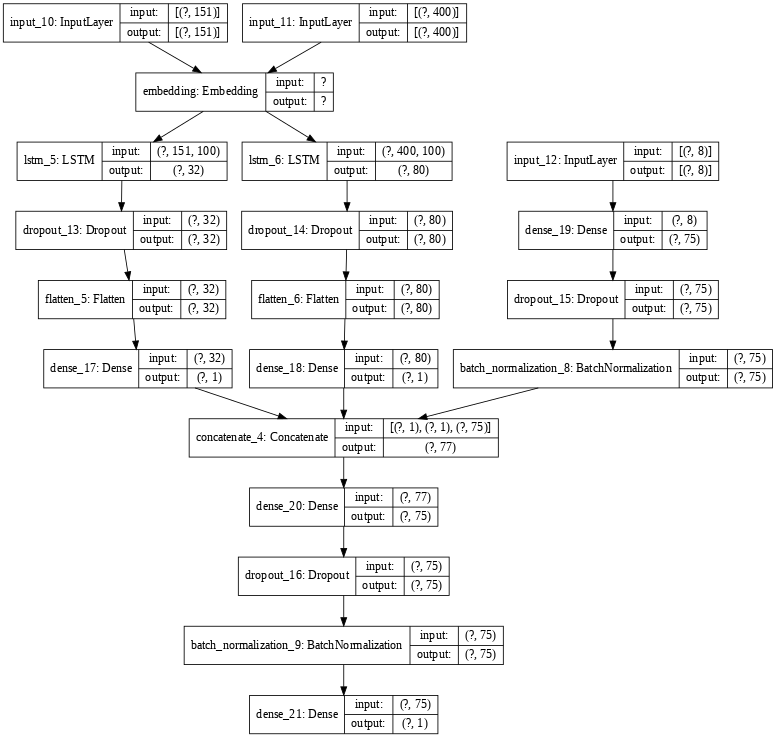

In [0]:
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
model = nn_model_3(75, 32, 80, length1, length2, length3, vocab_size, metrics, embedding_motion, embedding_speech, True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model2.hdf5', monitor='auc', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
plot_model(model, to_file='model2.png', show_shapes=True, dpi=60)

In [0]:
history = model.fit([Xtrain1, Xtrain2, Xtrain3.toarray()], y_train, epochs=120, batch_size=320, validation_data=([Xval1, Xval2, Xval3.toarray()], y_val), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)

Train on 1012 samples, validate on 113 samples
Epoch 1/120
1012/1012 [==============================] - 11s 11ms/sample - loss: 0.8706 - accuracy: 0.5020 - precision: 0.5592 - recall: 0.4875 - auc: 0.5097 - val_loss: 1.2686 - val_accuracy: 0.4867 - val_precision: 0.7143 - val_recall: 0.3425 - val_auc: 0.5723
Epoch 2/120
1012/1012 [==============================] - 6s 6ms/sample - loss: 0.8378 - accuracy: 0.5020 - precision: 0.5564 - recall: 0.5089 - auc: 0.5263 - val_loss: 1.0325 - val_accuracy: 0.4867 - val_precision: 0.7143 - val_recall: 0.3425 - val_auc: 0.5728
Epoch 3/120
1012/1012 [==============================] - 6s 6ms/sample - loss: 0.8674 - accuracy: 0.4941 - precision: 0.5456 - recall: 0.5320 - auc: 0.4877 - val_loss: 0.9024 - val_accuracy: 0.5398 - val_precision: 0.7333 - val_recall: 0.4521 - val_auc: 0.5771
Epoch 4/120
1012/1012 [==============================] - 6s 6ms/sample - loss: 0.8239 - accuracy: 0.5257 - precision: 0.5740 - recall: 0.5658 - auc: 0.5200 - val_loss: 

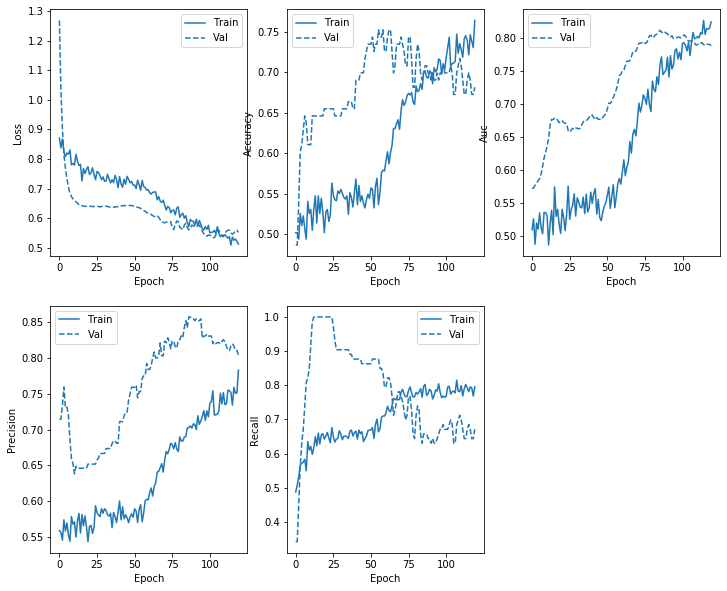

In [0]:
plot_metrics(history)

In [0]:
# Evaluate the accuracy of the best model on test set
model.load_weights("best_model2.hdf5")
results = model.evaluate([Xtest1, Xtest2, Xtest3.toarray()], y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.5919779321504017
accuracy :  0.6984127
precision :  0.73913044
recall :  0.7183099
auc :  0.7460947



*Pretrained embeddings did not provide much improvement.*

--------------------------------------------------------------------------------********************************************************************************--------------------------------------------------------------------------------<br/>
**Data Augmentation**<br/>
Since we have a small dataset, we decided to augment the data. We are using two methods.
1. Word Embeddings - Create new motions and utterances by using synonym words. The synonym words are found using word embeddings by finding 3 most nearest neighbours based on embedding vector similarity. Referred: https://www.kaggle.com/theoviel/using-word-embeddings-for-data-augmentation
2. Speech Generation - Train a speech generation model on a bigger Hansard corpus obtained using this link https://evanodell.com/projects/datasets/hansard-data/. This dataset only contains speeches for different MPs (no motion or speech labels). We want to train a model on these speeches and use transfer learning to generate new utterances for our stance dataset.

In [0]:
# Number of training examples in each of the four categories
hansard.groupby(['manual motion', 'manual speech']).size()

manual motion  manual speech
0              0                228
               1                527
1              0                317
               1                179
dtype: int64

As we can see, there are almost double the count of training examples with negative motion(label=0) and speech in favour of the motion(label=1). Thus we will try to generate more examples for the categories and make them more balanced.<br/>
We will remove stopwords from the text (motion + speech) and all words of length <=4 -> fit a new tokenizer -> create an embedding matrix

In [0]:
# remove stopwords and words with length < 3
text = hansard['cleaned_motion'] + hansard['cleaned_speech']
cleaned_text = text.apply(lambda x: ' '.join([word for word in x.split() if (word not in stopword) and len(word)>=5]))

# Fit tokenizer and pad sequences
tokenizer2 = Tokenizer(num_words=1000)
tokenizer2.fit_on_texts(cleaned_text)
word_index2 = tokenizer2.word_index
motion_seq = tokenizer2.texts_to_sequences(hansard['cleaned_motion'])
utt1_seq = tokenizer2.texts_to_sequences(hansard['utt1'])
utt2_seq = tokenizer2.texts_to_sequences(hansard['utt2'])
utt3_seq = tokenizer2.texts_to_sequences(hansard['utt3'])
utt4_seq = tokenizer2.texts_to_sequences(hansard['utt4'])
utt5_seq = tokenizer2.texts_to_sequences(hansard['utt5'])

# We have kept the motion length as 150 and the utterance length as 100
padded_motion = pad_sequences(motion_seq, 150)
padded_utt1 = pad_sequences(utt1_seq, 100)
padded_utt2 = pad_sequences(utt2_seq, 100)
padded_utt3 = pad_sequences(utt3_seq, 100)
padded_utt4 = pad_sequences(utt4_seq, 100)
padded_utt5 = pad_sequences(utt5_seq, 100)

# create a embedding matrix for the words 
embed_mat_syn = np.zeros((len(word_index2) + 1, 100))
for word, i in word_index2.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embed_mat_syn[i] = embedding_vector



In [43]:
from sklearn.neighbors import NearestNeighbors

# create the index-word pair dictionary
index_word = {0: ''}
for word in tokenizer2.word_index.keys():
    index_word[tokenizer2.word_index[word]] = word

# Find 3 most nearest neighbours
synonyms_number = 4
word_number = 1000
nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat_syn) 

# Find synonyms for words
neighbours_mat = nn.kneighbors(embed_mat_syn[1:word_number+1])[1]
synonyms = {x[0]: x[1:] for x in neighbours_mat}

# Print synonyms
for x in np.random.randint(1, word_number, 10):
    print(f"{index_word[x]} : {[index_word[synonyms[x][i]] for i in range(synonyms_number-1)]}")



local : ['addition', 'private', 'according']
reduce : ['reducing', 'reduced', 'eliminate']
pharmacies : ['pharmacists', 'supermarkets', 'pharmacy']
broken : ['breaking', 'apart', 'broke']
immediately : ['quickly', 'taken', 'later']
makes : ['gives', 'comes', 'making']
labour : ['tories', 'liberal', 'opposition']
approach : ['approaches', 'strategy', 'rather']
introduced : ['introduction', 'adopted', 'introducing']
motion : ['motions', 'action', 'appeal']


In [0]:
# The method swaps a word with a synonymy randomly if the probability is greater than p
def modify_sentence(sentence, synonyms, p=0.5):
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence

# Method to generate a modified sentence by replacing words with synonyms
def generate_sent_per_index(data):
  new_sentences = []
  for x in data:   
    sample =  np.trim_zeros(x)
    modified = modify_sentence(sample, synonyms)
    sentence_m = ' '.join([index_word[x] for x in modified])
    new_sentences.append(sentence_m)
  return new_sentences

# We are generating 'count' number of new sentences
def generate_sent(motion_data, utt1_data, utt2_data, utt3_data, utt4_data, utt5_data, count):
  indexes = np.random.randint(0, motion_data.shape[0], count)
  motions = generate_sent_per_index(motion_data[indexes])
  utt1 = generate_sent_per_index(utt1_data[indexes])
  utt2 = generate_sent_per_index(utt2_data[indexes])
  utt3 = generate_sent_per_index(utt3_data[indexes])
  utt4 = generate_sent_per_index(utt4_data[indexes])
  utt5 = generate_sent_per_index(utt5_data[indexes])
  return motions, utt1, utt2, utt3, utt4, utt5, indexes

# Method creates a new dataframe with modified sentences along with other columns
def augment_data(motion_data, utt1_data, utt2_data, utt3_data, utt4_data, utt5_data, df, count):
  motions, utt1, utt2, utt3, utt4, utt5, indexes = generate_sent(motion_data, utt1_data, utt2_data, utt3_data, utt4_data, utt5_data, count)
  df = df.iloc[indexes]
  df.reset_index(drop=True, inplace=True)
  df['cleaned_motion'] = pd.Series(motions)
  df['utt1'] = pd.Series(utt1)
  df['utt2'] = pd.Series(utt2)
  df['utt3'] = pd.Series(utt3)
  df['utt4'] = pd.Series(utt4)
  df['utt5'] = pd.Series(utt5)
  cols = ['utt1', 'utt2', 'utt3', 'utt4', 'utt5']
  df["cleaned_speech"] = df[cols].apply(lambda x: ' '.join(x.dropna()), axis=1)
  return df


In [45]:
# Generate data for each category to get a balanced dataset
true_values = (hansard['manual motion']==0) & (hansard['manual speech']==0)
motion_data = padded_motion[true_values]
utt1_data = padded_utt1[true_values]
utt2_data = padded_utt2[true_values]
utt3_data = padded_utt3[true_values]
utt4_data = padded_utt4[true_values]
utt5_data = padded_utt5[true_values]
df1 = hansard.loc[true_values, ['id', 'manual motion',	'motion party affiliation',	'manual speech',	'party affiliation']]
df1.reset_index(drop=True, inplace=True)
df1 = augment_data(motion_data, utt1_data, utt2_data, utt3_data, utt4_data, utt5_data, df1, 450).dropna()

true_values = (hansard['manual motion']==1) & (hansard['manual speech']==0)
motion_data = padded_motion[true_values]
utt1_data = padded_utt1[true_values]
utt2_data = padded_utt2[true_values]
utt3_data = padded_utt3[true_values]
utt4_data = padded_utt4[true_values]
utt5_data = padded_utt5[true_values]
df2 = hansard.loc[true_values, ['id', 'manual motion',	'motion party affiliation',	'manual speech',	'party affiliation']]
df2.reset_index(drop=True, inplace=True)
df2 = augment_data(motion_data, utt1_data, utt2_data, utt3_data, utt4_data, utt5_data, df2, 360).dropna()

true_values = (hansard['manual motion']==1) & (hansard['manual speech']==1)
motion_data = padded_motion[true_values]
utt1_data = padded_utt1[true_values]
utt2_data = padded_utt2[true_values]
utt3_data = padded_utt3[true_values]
utt4_data = padded_utt4[true_values]
utt5_data = padded_utt5[true_values]
df3 = hansard.loc[true_values, ['id', 'manual motion',	'motion party affiliation',	'manual speech',	'party affiliation']]
df3.reset_index(drop=True, inplace=True)
df3 = augment_data(motion_data, utt1_data, utt2_data, utt3_data, utt4_data, utt5_data, df3, 500).dropna()

true_values = (hansard['manual motion']==0) & (hansard['manual speech']==1)
motion_data = padded_motion[true_values]
utt1_data = padded_utt1[true_values]
utt2_data = padded_utt2[true_values]
utt3_data = padded_utt3[true_values]
utt4_data = padded_utt4[true_values]
utt5_data = padded_utt5[true_values]
df4 = hansard.loc[true_values, ['id', 'manual motion',	'motion party affiliation',	'manual speech',	'party affiliation']]
df4.reset_index(drop=True, inplace=True)
df4 = augment_data(motion_data, utt1_data, utt2_data, utt3_data, utt4_data, utt5_data, df4, 150).dropna()

# Concatenate the dataframes
df = pd.concat([df1, df2, df3, df4])
df = preprocess_data(df, True)
hansard = pd.concat([hansard, df]).reset_index(drop=True)
hansard.tail()

,cleaned_motion,cleaned_speech,id,manual motion,manual speech,motion party affiliation,motion_score,party affiliation,speech_ques_words,speech_score,speech_word_count,utt1,utt2,utt3,utt4,utt5
2706,distinguishes contribution health nursing offi...,members weeks spent since hospitals issue long...,121,0,1,1,0.1531,1,0,0.6908,27,members weeks spent since hospitals issue long...,instead essential though anything coming secon...,,,
2707,thinks failing deliver recovery female making ...,making powerful remarks child constituency par...,69,0,1,1,-0.2023,1,0,0.4215,14,making powerful remarks,child constituency parents place expense takes...,,,
2708,opposes basic minimum patients treated within ...,often point decisions local groups would secre...,105,0,1,1,0.7717,1,0,0.0000,18,often point decisions local groups would secre...,,,,
2709,aware taking decision compensate shame facing ...,accept essential debate equalisation agreed wa...,102,0,1,3,0.5719,1,0,0.5719,12,accept essential debate equalisation agreed wa...,,,,
2710,regrets continued balancing economy government...,great public sectors sector investment since i...,129,0,1,3,0.8271,3,0,-0.5267,22,great public sectors sector investment since i...,,,,


In [0]:
print(hansard.shape)
hansard.groupby(['manual motion', 'manual speech']).size()

(2711, 16)


manual motion  manual speech
0              0                678
               1                677
1              0                677
               1                679
dtype: int64

As we can see above, now the classes are almost balanced and we have more data. Let us train the neural network models on this new data and evaluate the accuracy.

In [49]:
# 1. Multi-Channel NN with LSTM - nn_model_2

# split the augmented data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(hansard, hansard['manual speech'], test_size=0.1)

# Generate tfidf values
tfidf_motion, tfidf_motion_test, tfidf_speech, tfidf_speech_test = generate_tfidf_val(x_train, x_test)

# Create the additional feature matrix by adding extra features
tfidf = add_feature(tfidf_motion, tfidf_speech, [x_train['id'], x_train['motion party affiliation'], x_train['manual motion'], x_train['party affiliation'], x_train['speech_ques_words'], x_train['motion_score'],	x_train['speech_score'], x_train['speech_word_count']])
tfidf_test = add_feature(tfidf_motion_test, tfidf_speech_test, [x_test['id'], x_test['motion party affiliation'], x_test['manual motion'], x_test['party affiliation'], x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'],  x_test['speech_word_count']])

print('TF-IDF train matrix shape: ', tfidf.shape)
print('TF-IDF test matrix shape: ', tfidf_test.shape)

# reshape data to feed to the LSTM layer
xtrain, xval, xtest, xtrain2, xval2, xtest2, ytrain, yval, ytest = reshape_data_lstm(x_train, x_test, y_test, tfidf_motion, tfidf_speech)


TF-IDF train matrix shape:  (2439, 24187)
TF-IDF test matrix shape:  (272, 24187)


In [0]:
# Fit the neural network
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model3.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
model = nn_model_2(60, xtrain2.shape[1], metrics)
history = model.fit([xtrain, xtrain2.toarray()], ytrain, epochs=80, batch_size=300, validation_data=([xval, xval2.toarray()], yval), shuffle=True, callbacks=[checkpoint], verbose=1)

Train on 2195 samples, validate on 244 samples
Epoch 1/80
2195/2195 [==============================] - 5s 2ms/sample - loss: 0.9326 - accuracy: 0.4943 - precision: 0.4896 - recall: 0.4106 - auc: 0.4815 - val_loss: 1.4261 - val_accuracy: 0.5574 - val_precision: 0.5574 - val_recall: 1.0000 - val_auc: 0.5263
Epoch 2/80
2195/2195 [==============================] - 1s 407us/sample - loss: 0.8982 - accuracy: 0.4961 - precision: 0.4926 - recall: 0.4555 - auc: 0.4957 - val_loss: 0.9506 - val_accuracy: 0.5574 - val_precision: 0.5574 - val_recall: 1.0000 - val_auc: 0.5327
Epoch 3/80
2195/2195 [==============================] - 1s 393us/sample - loss: 0.8472 - accuracy: 0.5084 - precision: 0.5058 - recall: 0.4821 - auc: 0.5137 - val_loss: 0.7884 - val_accuracy: 0.5656 - val_precision: 0.5625 - val_recall: 0.9926 - val_auc: 0.5450
Epoch 4/80
2195/2195 [==============================] - 1s 360us/sample - loss: 0.8531 - accuracy: 0.5071 - precision: 0.5041 - recall: 0.5041 - auc: 0.5031 - val_loss: 

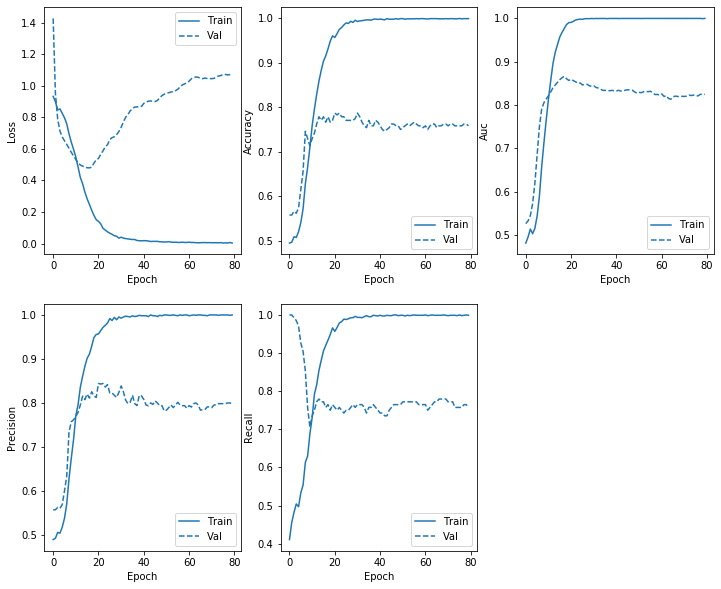

In [0]:
plot_metrics(history)

In [0]:

# Evaluate the accuracy of the best model on test set
model.load_weights("best_model3.hdf5")
results = model.evaluate([xtest, xtest2.toarray()], ytest, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.7373383395812091
accuracy :  0.7941176
precision :  0.78740156
recall :  0.7751938
auc :  0.87949264



*With more data we get a significant improvement in auc of 0.87 compared to ealier score of 0.76*

In [0]:
# Glove with LSTM  - nn_model_3
x_train, x_val, y_train, y_val = train_test_split(x_train, x_train['manual speech'], test_size=0.1)
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# Tokenize the data
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(x_train['cleaned_motion'] + x_train['cleaned_speech'])
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

Xtrain1, Xval1, Xtest1, length1 = create_embedding_text(tokenizer, x_train['cleaned_motion'], x_val['cleaned_motion'], x_test['cleaned_motion'], None)
Xtrain2, Xval2, Xtest2, length2 = create_embedding_text(tokenizer, x_train['cleaned_speech'], x_val['cleaned_speech'], x_test['cleaned_speech'], 400)
Xtrain3 = add_feature(None, None, [x_train['id'], x_train['motion party affiliation'], x_train['party affiliation'], x_train['manual motion'], x_train['speech_ques_words'], x_train['motion_score'], x_train['speech_score'], x_train['speech_word_count']])
Xval3 = add_feature(None, None, [x_val['id'], x_val['motion party affiliation'], x_val['party affiliation'], x_val['manual motion'], x_val['speech_ques_words'], x_val['motion_score'], x_val['speech_score'], x_val['speech_word_count']])
Xtest3 = add_feature( None, None, [x_test['id'], x_test['motion party affiliation'], x_test['party affiliation'], x_test['manual motion'],x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'], x_test['speech_word_count']])
length3 = Xtrain3.shape[1]

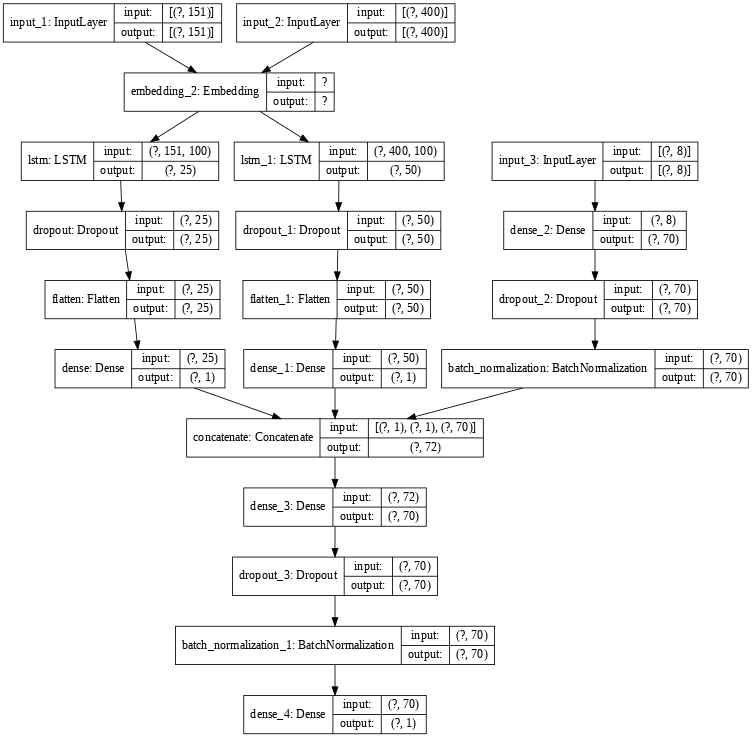

In [0]:
# create embedding matrices
embedding_matrix = create_embedding_matrix(word_index, EMBEDDING_DIM, embeddings_index)
embedding_motion = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=length1, trainable=False)
embedding_speech = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=length2, trainable=False)
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
model = nn_model_3(70, 25, 50, length1, length2, length3, vocab_size, metrics, embedding_motion, embedding_speech, True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model4.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=120, verbose=0, mode='min')
plot_model(model, to_file='model3.png', show_shapes=True, dpi=60)

In [0]:
history = model.fit([Xtrain1, Xtrain2, Xtrain3.toarray()], y_train, epochs=200, batch_size=420, validation_data=([Xval1, Xval2, Xval3.toarray()], y_val), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)

Train on 2195 samples, validate on 244 samples
Epoch 1/200
2195/2195 [==============================] - 13s 6ms/sample - loss: 0.8546 - accuracy: 0.5043 - precision: 0.4959 - recall: 0.4519 - auc: 0.5059 - val_loss: 0.9218 - val_accuracy: 0.5287 - val_precision: 0.5482 - val_recall: 0.9124 - val_auc: 0.4815
Epoch 2/200
2195/2195 [==============================] - 8s 4ms/sample - loss: 0.8567 - accuracy: 0.5025 - precision: 0.4941 - recall: 0.4667 - auc: 0.4961 - val_loss: 0.7819 - val_accuracy: 0.5287 - val_precision: 0.5514 - val_recall: 0.8613 - val_auc: 0.5002
Epoch 3/200
2195/2195 [==============================] - 8s 4ms/sample - loss: 0.8449 - accuracy: 0.5098 - precision: 0.5020 - recall: 0.4630 - auc: 0.4991 - val_loss: 0.7336 - val_accuracy: 0.5328 - val_precision: 0.5608 - val_recall: 0.7737 - val_auc: 0.5086
Epoch 4/200
2195/2195 [==============================] - 8s 4ms/sample - loss: 0.8268 - accuracy: 0.5103 - precision: 0.5024 - recall: 0.4815 - auc: 0.5042 - val_loss: 0

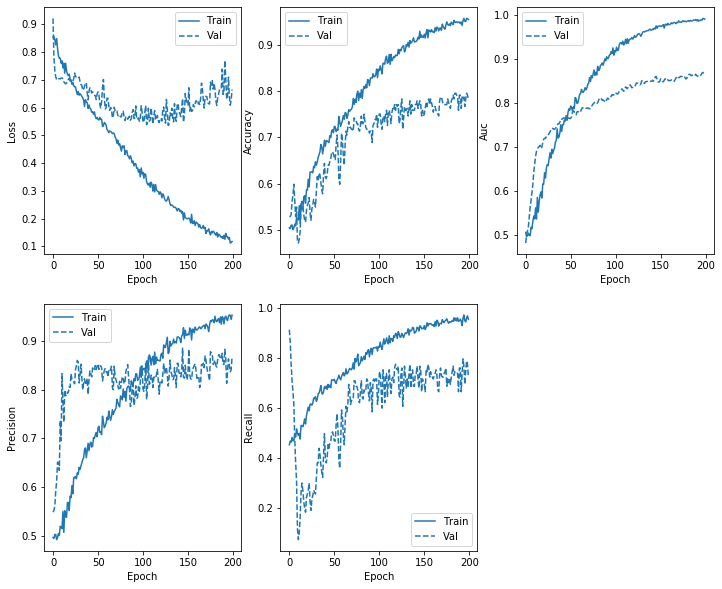

In [0]:
plot_metrics(history)

In [0]:
# Evaluate the accuracy of the best model on test set
model.load_weights("best_model4.hdf5")
results = model.evaluate([Xtest1, Xtest2, Xtest3.toarray()], y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.6008129102342269
accuracy :  0.7867647
precision :  0.77931035
recall :  0.81294966
auc :  0.86852926



*Again, using embeddings model does not provide much improvement over the NN model with tfidf. We thought this maybe because we have considered bigrams and trigrams for the tfidf features. So we tried using CNN with kernel size 2 and 3 along with LSTM in one of the upcoming models to verify if it provides better results.*

**4. LSTM + Trained Embedding Layer**<br/>
We also trained the above mode (nn_model_3) using a trainable embedding layer but it gives very low score (0.78) compared to the glove model (0.87). This is due to a lot of trainable parameters including the embedding layer. So the model overfits the data.

In [0]:
# pretrained argument is set as False since we want to train a new Embedding layer
model = nn_model_3(60, 15, 30, length1, length2, length3, vocab_size, metrics, embedding_motion, embedding_speech, False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model5.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
history = model.fit([Xtrain1, Xtrain2, Xtrain3.toarray()], y_train, epochs=40, batch_size=400, validation_data=([Xval1, Xval2, Xval3.toarray()], y_val), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)

Train on 2195 samples, validate on 244 samples
Epoch 1/40
2195/2195 [==============================] - 11s 5ms/sample - loss: 0.8643 - accuracy: 0.4979 - precision: 0.4899 - recall: 0.4935 - auc: 0.4936 - val_loss: 0.7833 - val_accuracy: 0.5123 - val_precision: 0.5425 - val_recall: 0.8394 - val_auc: 0.4463
Epoch 2/40
2195/2195 [==============================] - 6s 3ms/sample - loss: 0.8554 - accuracy: 0.4989 - precision: 0.4904 - recall: 0.4731 - auc: 0.4879 - val_loss: 0.7210 - val_accuracy: 0.5369 - val_precision: 0.5550 - val_recall: 0.8832 - val_auc: 0.4678
Epoch 3/40
2195/2195 [==============================] - 6s 3ms/sample - loss: 0.8245 - accuracy: 0.5080 - precision: 0.5000 - recall: 0.4824 - auc: 0.5097 - val_loss: 0.7001 - val_accuracy: 0.5410 - val_precision: 0.5576 - val_recall: 0.8832 - val_auc: 0.4892
Epoch 4/40
2195/2195 [==============================] - 6s 3ms/sample - loss: 0.8206 - accuracy: 0.4856 - precision: 0.4765 - recall: 0.4593 - auc: 0.4968 - val_loss: 0.687

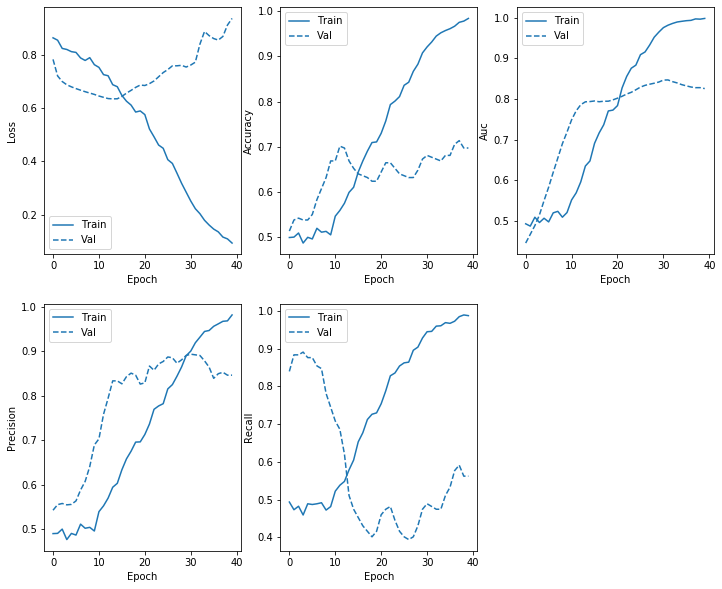

In [0]:
plot_metrics(history)

In [0]:
# Evaluate the accuracy of the best model on test set
model.load_weights("best_model5.hdf5")
results = model.evaluate([Xtest1, Xtest2, Xtest3.toarray()], y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  1.0210856970618754
accuracy :  0.6691176
precision :  0.7378641
recall :  0.5467626
auc :  0.7793044



In [0]:
del tfidf_motion, tfidf_speech, tfidf_motion_test, tfidf_speech_test, embed_mat_syn

----------------------------------------------------------------------------------------------------------------------------------------------------------------
**5. Multi-Channel Neural Net with CNN and LSTM**</br>
Now let us include CNNs in our model to extract bigrams(kernel_size=2) and trigrams(kernel size=3)


In [0]:
# Mutli-channel nn model
def nn_model_4(n_neurons, length1, length2, length3, metrics):
  # channel 1 for motion text with LSTM (unigram features)
  inputs0 = Input(shape=(length1,))
  embedding0 = embedding_motion(inputs0)
  lstm0 = LSTM(30, input_shape=(1, xtrain.shape[2]), recurrent_dropout=0.7)(embedding0)
  drop0 = Dropout(rate=0.5)(lstm0)
  flat0 = Flatten()(drop0)

  # channel 2 for motion text with CNN and LSTM (bigram features with kernel_size 2)
  inputs1 = Input(shape=(length1,))
  embedding1 = embedding_motion(inputs1)
  cnn1 = Conv1D(filters=15, kernel_size=2, activation='relu')(embedding1)
  pool1 = MaxPooling1D(pool_size=2)(cnn1)
  lstm1 = LSTM(20, input_shape=(1, xtrain.shape[2]), recurrent_dropout=0.7)(pool1)
  drop1 = Dropout(rate=0.7)(lstm1)
  flat1 = Flatten()(drop1)


  # channel 3 for speech text with CNN and LSTM (bigram features with kernel_size 2)
  inputs2 = Input(shape=(length2,))
  embedding2 = embedding_speech(inputs2)
  cnn2 = Conv1D(filters=15, kernel_size=2, activation='relu')(embedding2)
  pool2 = MaxPooling1D(pool_size=2)(cnn2)
  lstm2 = LSTM(20, input_shape=(1, xtrain.shape[2]), recurrent_dropout=0.7)(pool2)
  drop2 = Dropout(rate=0.7)(lstm2)
  flat2 = Flatten()(drop2)


  # channel 4 for speech text with CNN and LSTM (trigram features with kernel_size 3)
  inputs3 = Input(shape=(length2,))
  embedding3 = embedding_speech(inputs3)
  cnn3 = Conv1D(filters=12, kernel_size=3, activation='relu')(embedding3)
  pool3 = MaxPooling1D(pool_size=2)(cnn3)
  lstm3 = LSTM(15, input_shape=(1, xtrain.shape[2]), recurrent_dropout=0.7)(pool3)
  drop3 = Dropout(rate=0.7)(lstm3)
  flat3 = Flatten()(drop3)


  # channel 5 for speech text with LSTM (unigram features)
  inputs4 = Input(shape=(length2,))
  embedding4 = embedding_speech(inputs4)
  lstm4 = LSTM(40, input_shape=(1, xtrain.shape[2]), recurrent_dropout=0.7)(embedding4)
  drop4 = Dropout(rate=0.7)(lstm4)
  flat4 = Flatten()(drop4)


  # channel 6 for numeric features
  inputs5 = Input(shape=(length3,))
  dense5 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs5)
  drop5 = Dropout(rate=0.7)(dense5)
  bn5 = BatchNormalization()(drop5)

  # merge
  merged = concatenate([flat0, flat1, flat2, flat3, flat4, bn5])

  # shared
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(merged)
  drop3 = Dropout(rate=0.7)(dense3)
  bn3 = BatchNormalization()(drop3)
  outputs = Dense(1, activation='sigmoid')(bn3)
  model = Model(inputs=[inputs0, inputs1, inputs2, inputs3, inputs4, inputs5], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
  return model



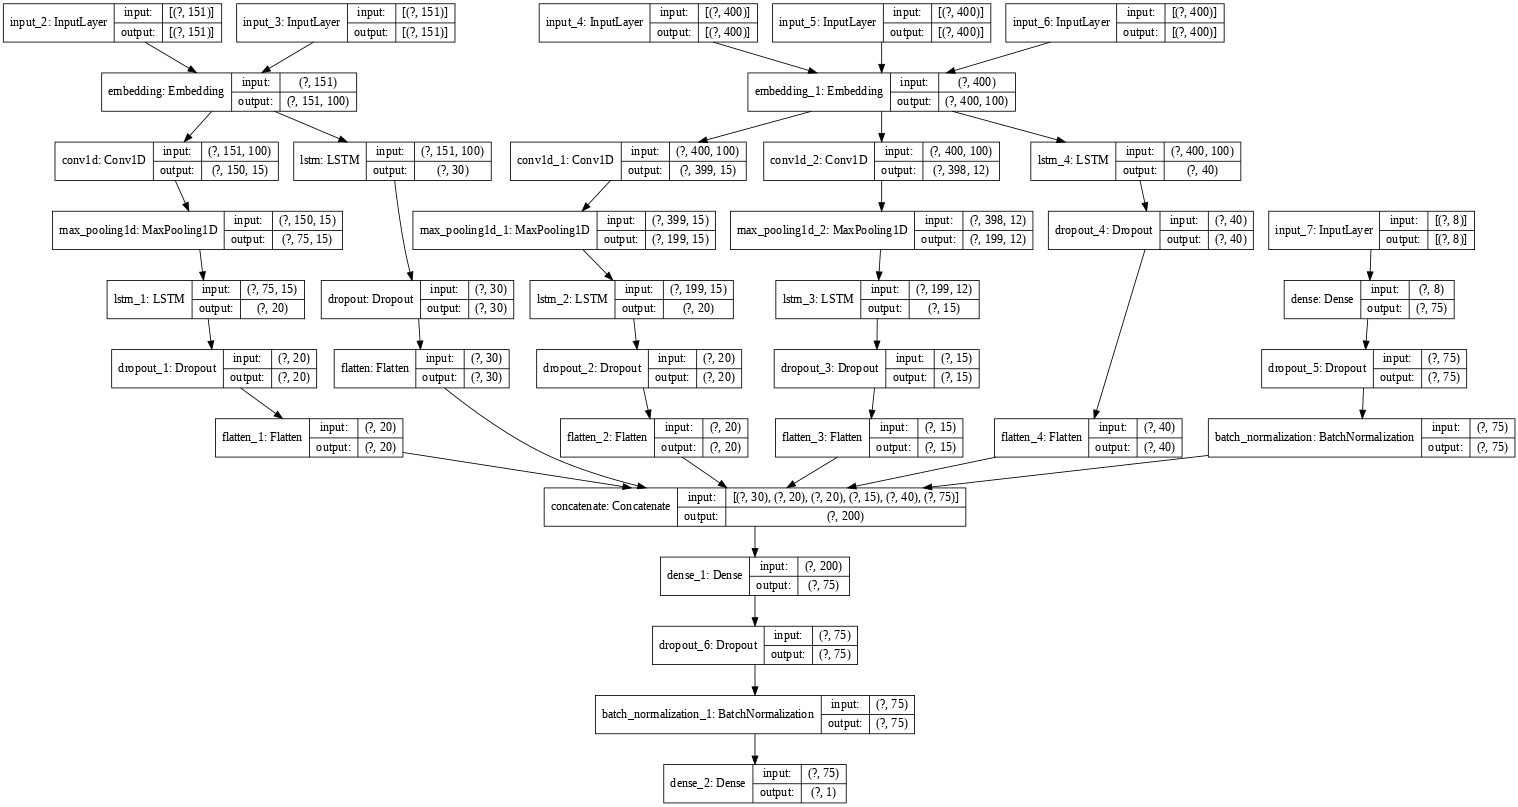

In [0]:
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model6.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')
model = nn_model_4(75, length1, length2, length3, metrics)
plot_model(model, to_file='model6.png', show_shapes=True, dpi=60)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 151)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 151)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 400)]        0                                            
______________________________________________________________________________________________

In [0]:
history = model.fit([Xtrain1, Xtrain1, Xtrain2, Xtrain2, Xtrain2, Xtrain3.toarray()], y_train, epochs=150, batch_size=450, validation_data=([Xval1, Xval1, Xval2, Xval2, Xval2, Xval3.toarray()], y_val), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)

Train on 2195 samples, validate on 244 samples
Epoch 1/150
2195/2195 [==============================] - 17s 8ms/sample - loss: 0.9047 - accuracy: 0.4934 - precision: 0.4977 - recall: 0.4860 - auc: 0.4826 - val_loss: 0.9414 - val_accuracy: 0.4426 - val_precision: 0.4623 - val_recall: 0.8167 - val_auc: 0.4926
Epoch 2/150
2195/2195 [==============================] - 8s 4ms/sample - loss: 0.8783 - accuracy: 0.5025 - precision: 0.5067 - recall: 0.5095 - auc: 0.4994 - val_loss: 0.8047 - val_accuracy: 0.4672 - val_precision: 0.4766 - val_recall: 0.8500 - val_auc: 0.5033
Epoch 3/150
2195/2195 [==============================] - 8s 4ms/sample - loss: 0.8382 - accuracy: 0.5130 - precision: 0.5174 - recall: 0.5104 - auc: 0.5202 - val_loss: 0.7514 - val_accuracy: 0.4877 - val_precision: 0.4880 - val_recall: 0.8500 - val_auc: 0.5122
Epoch 4/150
2195/2195 [==============================] - 8s 4ms/sample - loss: 0.8476 - accuracy: 0.5075 - precision: 0.5117 - recall: 0.5122 - auc: 0.5133 - val_loss: 0

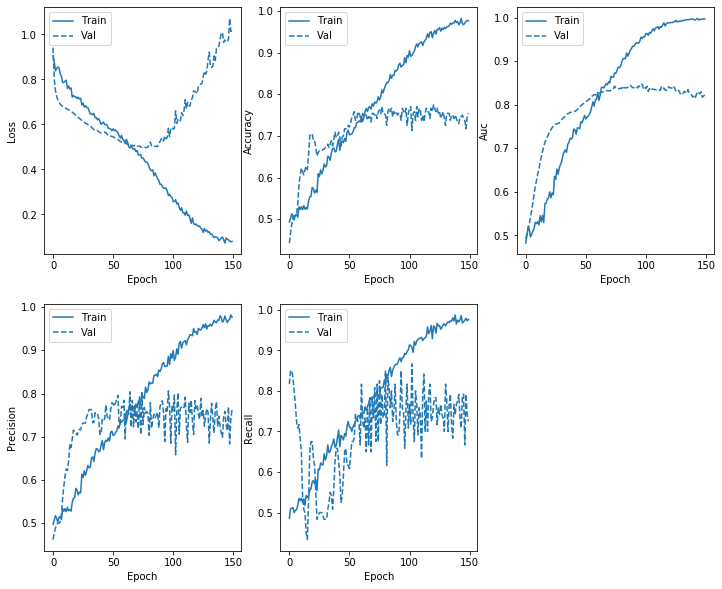

In [0]:
plot_metrics(history)

In [0]:
# Evaluate the accuracy of the best model on test set
model.load_weights("best_model6.hdf5")
results = model.evaluate([Xtest1, Xtest1, Xtest2, Xtest2, Xtest2, Xtest3.toarray()], y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.6291578517240637
accuracy :  0.7941176
precision :  0.796748
recall :  0.7596899
auc :  0.87848973



*As we see, including CNNs for bigrams, trigrams gave a similar accuracy compared to tfidf model. But the CNN model also shows severe overfitting as there are 71,488 trainable parameters and only 2195 training examples. Thus, there is not much improvement in accuracy over the previous models*

**6. Bi-LSTM with Glove Embeddings/TFIDF features**<br/>
We trained a BI-LSTM model similar to the one implemented in this paper https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1174/reports/2760496.pdf. Instead of the Global Features we are providing the numeric features of our dataset. We trained the model with embeddings and also with tfidf features

In [0]:
def nn_model_5(n_neurons, h1, h2, length1, length2, length3, metrics, embedding_motion, embedding_speech):
  # channel 1 with BI-LSTM layer for motion text
  inputs1 = Input(shape=(length1,))
  embed1 = embedding_motion(inputs1)
  bilstm1 = Bidirectional(LSTM(h1, recurrent_dropout=0.7, return_state=True, return_sequences=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")
  output1, forward_h, forward_c, backward_h, backward_c = bilstm1(embed1)
    
  # The forward and backward hidden/cell states are passed as an initial input to the speech BI-LSTM
  # The hidden states and cell states are concatenated separately and merged and trained with the output of speech bilstm and numeric channel
  state_h = concatenate([forward_h, backward_h])
  flat1 = Flatten()(state_h)
  state_c = concatenate([forward_c, backward_c])
  flat2 = Flatten()(state_c)
  initial_states = [forward_h, forward_c, backward_h, backward_c]

  # channel 2 with BI-LSTM for speech text
  inputs2 = Input(shape=(length2,))
  embed2 = embedding_motion(inputs2)
  bilstm2 = Bidirectional(LSTM(h2, recurrent_dropout=0.7, return_sequences=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")(embed2, initial_state=initial_states)
  flat3 = Flatten()(bilstm2)

  # channel 3 for numeric features
  inputs3 = Input(shape=(length3,))
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs3)
  drop3 = Dropout(rate=0.7)(dense3)
  bn3 = BatchNormalization()(drop3)

  # merge
  merged = concatenate([flat1, flat2, flat3, bn3])

  # shared
  dense4 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(merged)
  drop4 = Dropout(rate=0.7)(dense4)
  bn4 = BatchNormalization()(drop4)
  outputs = Dense(1, activation='sigmoid')(bn4)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=metrics)
  return model

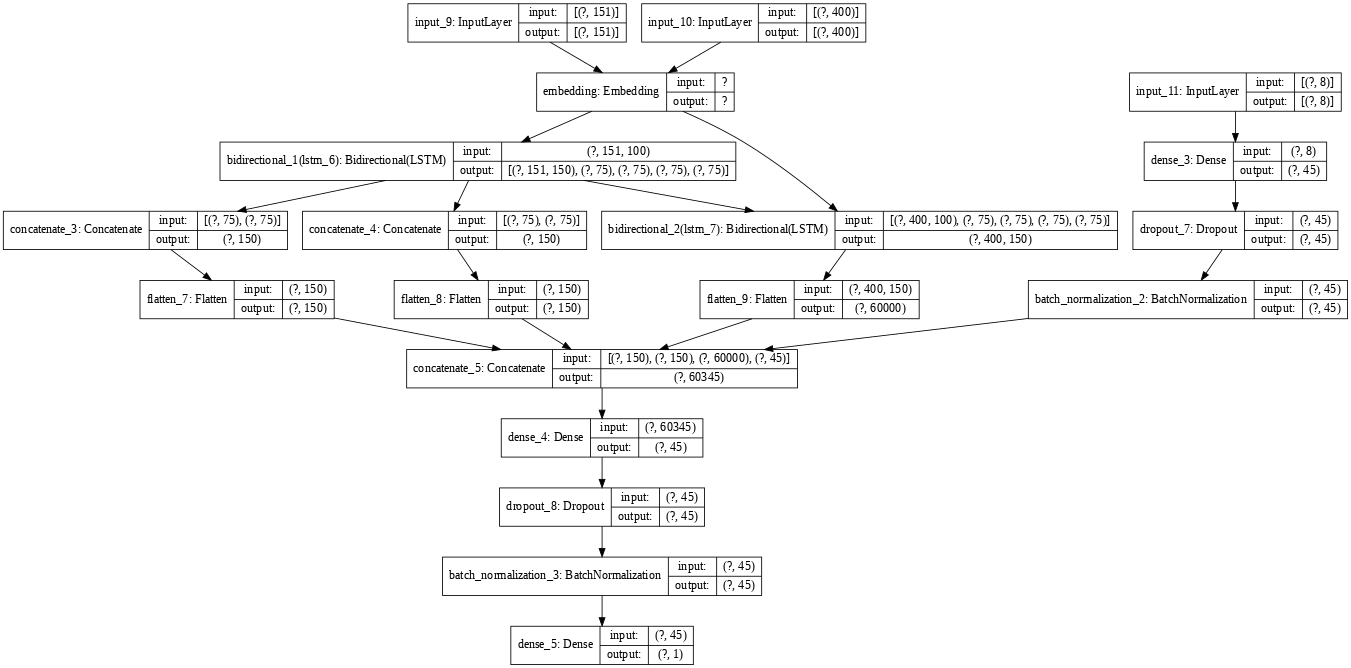

In [0]:
# create embedding matrices
model = nn_model_5(45, 75, 75, length1, length2, length3, metrics, embedding_motion, embedding_speech)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model7.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=80, verbose=0, mode='min')
plot_model(model, to_file='model7.png', show_shapes=True, dpi=60)  

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 151)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             1231900     input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 8)]          0                                      

In [0]:
history = model.fit([Xtrain1, Xtrain2, Xtrain3.toarray()], y_train, epochs=150, batch_size=500, validation_data=([Xval1, Xval2, Xval3.toarray()], y_val), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)


Train on 2195 samples, validate on 244 samples
Epoch 1/150
2195/2195 [==============================] - 25s 11ms/sample - loss: 0.9366 - accuracy: 0.5116 - precision: 0.5184 - recall: 0.4453 - auc: 0.5074 - val_loss: 1.4957 - val_accuracy: 0.4918 - val_precision: 0.4918 - val_recall: 1.0000 - val_auc: 0.5525
Epoch 2/150
2195/2195 [==============================] - 19s 9ms/sample - loss: 0.8685 - accuracy: 0.5075 - precision: 0.5133 - recall: 0.4544 - auc: 0.5212 - val_loss: 1.3854 - val_accuracy: 0.4918 - val_precision: 0.4918 - val_recall: 1.0000 - val_auc: 0.5811
Epoch 3/150
2195/2195 [==============================] - 19s 9ms/sample - loss: 0.8354 - accuracy: 0.5212 - precision: 0.5279 - recall: 0.4779 - auc: 0.5313 - val_loss: 1.2385 - val_accuracy: 0.4918 - val_precision: 0.4918 - val_recall: 1.0000 - val_auc: 0.5792
Epoch 4/150
2195/2195 [==============================] - 19s 9ms/sample - loss: 0.8398 - accuracy: 0.5134 - precision: 0.5192 - recall: 0.4770 - auc: 0.5171 - val_los

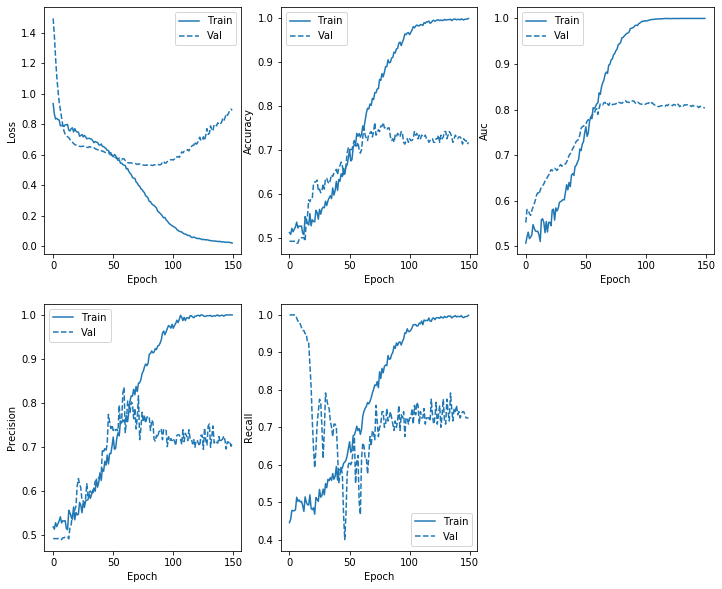

In [0]:
plot_metrics(history)

In [0]:
# Evaluate the accuracy of the best model on test set
model.load_weights("best_model7.hdf5")
results = model.evaluate([Xtest1, Xtest2, Xtest3.toarray()], y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.7092565052649554
accuracy :  0.7757353
precision :  0.76153845
recall :  0.76744187
auc :  0.84886426



**6. BI-LSTM model with Tfidf**

In [0]:
# create tfidf vectorizers
tfidf_vectorizer_motion = TfidfVectorizer(max_df=0.85, min_df=2, ngram_range=(1,3))
tfidf_vectorizer_speech = TfidfVectorizer(max_df=0.90, min_df=5, ngram_range=(1,3))

# transform motion text
tfidf_motion = tfidf_vectorizer_motion.fit_transform(x_train['cleaned_motion']) 
tfidf_motion_val = tfidf_vectorizer_motion.transform(x_val['cleaned_motion']) 
tfidf_motion_test = tfidf_vectorizer_motion.transform(x_test['cleaned_motion'])

# transform utterance text
tfidf_speech = tfidf_vectorizer_speech.fit_transform(x_train['cleaned_speech']) 
tfidf_speech_val = tfidf_vectorizer_speech.transform(x_val['cleaned_speech'])
tfidf_speech_test = tfidf_vectorizer_speech.transform(x_test['cleaned_speech'])

# reshape data
def reshape_data(xtrain, xval, xtest):
  xtrain = xtrain.toarray()
  xval = xval.toarray() 
  xtest=xtest.toarray()
  xtrain = xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1])
  xval = xval.reshape(xval.shape[0], 1, xval.shape[1])
  xtest = xtest.reshape(xtest.shape[0], 1, xtest.shape[1])
  return xtrain, xval, xtest

tfidf_motion, tfidf_motion_val, tfidf_motion_test = reshape_data(tfidf_motion, tfidf_motion_val, tfidf_motion_test)
tfidf_speech, tfidf_speech_val, tfidf_speech_test = reshape_data(tfidf_speech, tfidf_speech_val, tfidf_speech_test)

ytrain = y_train.reshape(y_train.shape[0], 1)
yval = y_val.reshape(y_val.shape[0], 1)
ytest = y_test.reshape(y_test.shape[0], 1)

In [0]:
def nn_model_6(n_neurons, h1, h2, length1, length2, length3, metrics):
  # channel 1 with BI-LSTM layer for motion text
  inputs1 = Input(shape=(1, length1))
  bilstm1 = Bidirectional(LSTM(h1, recurrent_dropout=0.7, return_state=True, return_sequences=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")
  output1, forward_h, forward_c, backward_h, backward_c = bilstm1(inputs1)
  
  # The forward and backward hidden/cell states are passed as an initial input to the speech BI-LSTM
  # The hidden states and cell states are concatenated separately and merged and trained with the output of speech bilstm and numeric channel
  state_h = concatenate([forward_h, backward_h])
  flat1 = Flatten()(state_h)
  state_c = concatenate([forward_c, backward_c])
  flat2 = Flatten()(state_c)
  initial_states = [forward_h, forward_c, backward_h, backward_c]

  # channel 2 with BI-LSTM for speech text
  inputs2 = Input(shape=(1, length2))
  bilstm2 = Bidirectional(LSTM(h2, recurrent_dropout=0.7, return_sequences=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")(inputs2, initial_state=initial_states)
  flat3 = Flatten()(bilstm2)

   # channel 3 for numeric features 
  inputs3 = Input(shape=(length3,))
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs3)
  drop3 = Dropout(rate=0.7)(dense3)
  bn3 = BatchNormalization()(drop3)

  # merge
  merged = concatenate([flat1, flat2, flat3, bn3])

  # shared
  dense4 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(merged)
  drop4 = Dropout(rate=0.7)(dense4)
  bn4 = BatchNormalization()(drop4)
  outputs = Dense(1, activation='sigmoid')(bn4)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=metrics)
  return model
 

In [0]:
# create embedding matrices
model = nn_model_6(15, 8, 8, tfidf_motion.shape[2], tfidf_speech.shape[2], length3, metrics)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model10.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, verbose=0, mode='min')
history = model.fit([tfidf_motion, tfidf_speech, Xtrain3.toarray()], ytrain, epochs=80, batch_size=500, validation_data=([tfidf_motion_val, tfidf_speech_val, Xval3.toarray()], y_val), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)
 

Train on 2195 samples, validate on 244 samples
Epoch 1/80
2195/2195 [==============================] - 7s 3ms/sample - loss: 0.8729 - accuracy: 0.5039 - precision: 0.5072 - recall: 0.5763 - auc: 0.4956 - val_loss: 0.7311 - val_accuracy: 0.4672 - val_precision: 0.4537 - val_recall: 0.4083 - val_auc: 0.4650
Epoch 2/80
2195/2195 [==============================] - 1s 315us/sample - loss: 0.8477 - accuracy: 0.5180 - precision: 0.5195 - recall: 0.5908 - auc: 0.5110 - val_loss: 0.7059 - val_accuracy: 0.4713 - val_precision: 0.4602 - val_recall: 0.4333 - val_auc: 0.4956
Epoch 3/80
2195/2195 [==============================] - 1s 289us/sample - loss: 0.8649 - accuracy: 0.5098 - precision: 0.5123 - recall: 0.5836 - auc: 0.5004 - val_loss: 0.6939 - val_accuracy: 0.4795 - val_precision: 0.4706 - val_recall: 0.4667 - val_auc: 0.5336
Epoch 4/80
2195/2195 [==============================] - 1s 296us/sample - loss: 0.8367 - accuracy: 0.4984 - precision: 0.5024 - recall: 0.5700 - auc: 0.5038 - val_loss: 

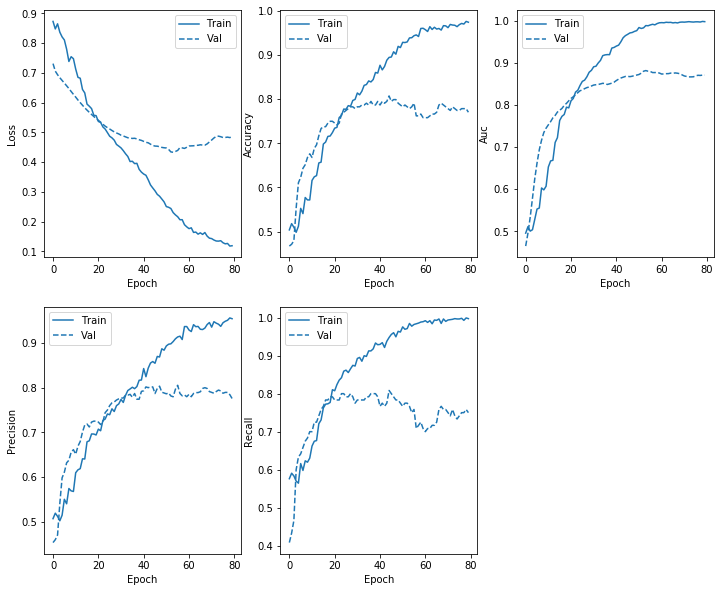

In [0]:
plot_metrics(history)

In [0]:
# Evaluate the accuracy of the best model on test set
model.load_weights("best_model10.hdf5")
results = model.evaluate([tfidf_motion_test, tfidf_speech_test, Xtest3.toarray()], y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.5842283333049101
accuracy :  0.77205884
precision :  0.768
recall :  0.74418604
auc :  0.82582533



**7. Utterance Level BI-LSTM with Forget/Update Gates**<br/>
We tried a novel model which derives the idea from attention network. The model trains over utterances separately instead of combined speech text. The model is described below:<br/>

*We use the following variables:*
- *motion_initial_states = \[forward_h, forward_c, backward_h, backward_c\] where forward_h and backward_h are forward and backward hidden states of the bi-lstm whereas forward_c and backward_c are forward and backward cell states*
- *motion_cell_state = \[forward_c, backward_c\]*
-  *motion_hidden_state = \[forward_h, backward_h\]*
- *utt\[i\]_cell_state = \[forward_c[i], backward_c[i]\] where i = \{1,2,3\}*
- *utt\[i\]_hidden_state = \[forward_h[i], backward_h[i]\]*
- *gate_input = \[motion_cell_state, utt\[i\]_cell_state\]*
- *$forget\_gate = \sigma(Weights*(gate\_in) + bias)$*
- *$update\_gate = \tanh(Weights*(gate\_in) + bias)$*


1. Motion text is passed through a BI-LSTM. 
2. Utterance 1, Utterance 2 and Utterance(3 + 4 + 5) are passed to a BI-LSTM layer separately with the intial states = motion intial states. This is done so that the utterances are trained conditioned on the motion features. This is similar to the Attention layer. We combine utterances 3, 4, and 5 because most training examples do not have utterance 4 and 5.
3. Utterance1_cell_state and motion_cell_state are concatenated and passed through a forget gate(sigmoid activation) and update gate(tanh activation) 
4. A new output (say 'out') is obtained by updating the utterance 1 cell state by multiplying the outputs of forget and update gates and adding together.
4. Hidden states of each cell of bilstm for utterance 1 are passed as input to utterance 2 bilstm. Similarly, hidden states of utterance 2 cells are passed to utterance 3.
5. Utterance2_cell_state and motion_cell_state are also concatenated and passed through the forget gate and update gate. These outputs are used to update the previously obtained output ('out') with utterance1_cell_state
6. Same step is followed for utterance3_cell_state
7. Motion_hidden_state, utt\[i\]_hidden_states, and 'out' are concatenated and passed through a dense layer
8. The output of the dense layer along with the output from the dense layer of numeric features is passed through a final dense layer with sigmoid activation.

In [0]:
def nn_model_7(gate_units, n_neurons, h1, h2, h3, length1, length, length3, metrics, embedding_motion, embedding_utt):
  # channel 1 for motion text
  # set return_state = True for bilstm to retrieve the forward and backward hidden/cell states
  inputs1 = Input(shape=(length1,))
  embed1 = embedding_motion(inputs1)
  bilstm1 = Bidirectional(LSTM(h1, recurrent_dropout=0.7, return_state=True, return_sequences=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")
  output, forward_h, forward_c, backward_h, backward_c = bilstm1(embed1)

  # Concatenate the hidden and cell states of motion bi-lstm
  motion_hidden_state = concatenate([forward_h, backward_h])
  motion_cell_state = concatenate([forward_c, backward_c])
  motion_cell_state = Flatten()(motion_cell_state)
  # Create the initial states variable to be passed to the utterance bi-lstms
  initial_states = [forward_h, forward_c, backward_h, backward_c]

  # channel 2.A for utterance 1
  inputs2 = Input(shape=(length,))
  embed2 = embedding_utt(inputs2)
  bilstm2 = Bidirectional(LSTM(h2, recurrent_dropout=0.7, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")
  output2, forward_h2, forward_c2, backward_h2, backward_c2 = bilstm2(embed2, initial_state=initial_states)

  utt1_hidden_state = concatenate([forward_h2, backward_h2])
  utt1_cell_state = tf.math.add(forward_c2, backward_c2)
  utt1_cell_state = Flatten()(utt1_cell_state)
  
  # Update the sentence outputs by applying gates
  gate_in = concatenate([motion_cell_state, utt1_cell_state])  
  # Forget Gate
  fout = Dense(gate_units, activation = "sigmoid")(gate_in)
  # Update Gate
  uout = Dense(gate_units, activation = "tanh")(gate_in)
  # Create a new output variable by adding the output of forget and update gate
  out = tf.math.add(tf.math.multiply(fout, utt1_cell_state), tf.math.multiply(uout, utt1_cell_state))
  
  # channel 2.B for utterance 2
  inputs3 = Input(shape=(length,))
  embed3 = embedding_utt(inputs3)
  # Hidden states of each cell of previous bilstm (utternace 1) are passed as input to the new bilstm along with embeddings
  comb_in1 = concatenate([output2, embed3])
  bilstm3 = Bidirectional(LSTM(h2, recurrent_dropout=0.7, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")
  output3, forward_h3, forward_c3, backward_h3, backward_c3 = bilstm3(comb_in1, initial_state=initial_states)
 
  utt2_hidden_state = concatenate([forward_h3, backward_h3])
  utt2_cell_state = tf.math.add(forward_c3, backward_c3)
  utt2_cell_state = Flatten()(utt2_cell_state)

  # Update the sentence outputs by applying gates
  gate_in = concatenate([motion_cell_state, utt2_cell_state])  
  # Forget Gate
  fout = Dense(gate_units, activation = "sigmoid")(gate_in)
  # Update Gate
  uout = Dense(gate_units, activation = "tanh")(gate_in)
  # Multiply the gate outputs to the previously created 'out' variable and add
  out = tf.math.add(tf.math.multiply(fout, out), tf.math.multiply(uout, out))

  # channel 2.C for utt3 + utt4 + utt5
  inputs4 = Input(shape=(length,))
  embed4 = embedding_utt(inputs4)
  # Hidden states of each cell of previous bilstm (utternace 2) are passed as input to the new bilstm along with embeddings
  comb_in2 = concatenate([output3, embed4])
  bilstm4 = Bidirectional(LSTM(h2, recurrent_dropout=0.7, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")
  output4, forward_h4, forward_c4, backward_h4, backward_c4 = bilstm4(comb_in2, initial_state=initial_states)
    
  utt3_hidden_state = concatenate([forward_h4, backward_h4])
  utt3_cell_state = tf.math.add(forward_c4, backward_c4)
  utt3_cell_state = Flatten()(utt3_cell_state)

  # Update the sentence outputs by applying gates
  gate_in = concatenate([motion_cell_state, utt3_cell_state]) 
  # Forget Gate 
  fout = Dense(gate_units, activation = "sigmoid")(gate_in)
  # Update Gates
  uout = Dense(gate_units, activation = "tanh")(gate_in)
  # Multiply the gate outputs to the previously updated 'out' variable and add
  out = tf.math.add(tf.math.multiply(fout, out), tf.math.multiply(uout, out))

  # channel 3 for numeric features
  inputs5 = Input(shape=(length3,))
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs5)
  drop3 = Dropout(rate=0.7)(dense3)
  bn3 = BatchNormalization()(drop3)

  # merge the cell_state ouput obtained by applying gates along with the hidden states of all bi-lstms
  # Feed it as input to a Dense layer
  merged = concatenate([out, motion_hidden_state, utt1_hidden_state, utt2_hidden_state, utt3_hidden_state])
  dense4 = Dense(h3, activation='tanh', kernel_initializer="he_normal")(merged)
  drop4 = Dropout(rate=0.7)(dense4)

  # merge the output of the previous dense layer along with the output of the dense layer for numeric features
  merged2 = concatenate([drop4, bn3])

  # shared final layer
  dense5 = Dense(n_neurons, activation='tanh', kernel_initializer="he_normal")(merged2)
  drop5 = Dropout(rate=0.7)(dense5)
  bn4 = BatchNormalization()(drop5)
  outputs = Dense(1, activation='sigmoid')(bn4)
  model = Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam', clipvalue=1, metrics=metrics)
  return model

Text(0, 0.5, 'Frequency')

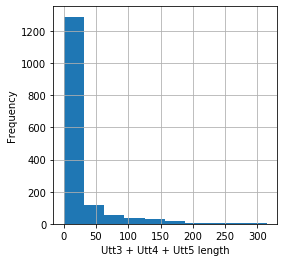

In [0]:
concat_utt = x_train['utt3']+x_train['utt4']
utt_count = concat_utt.apply(lambda x: len([w for w in x.split()]))
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
utt_count.hist()
plt.xlabel('Utt3 + Utt4 + Utt5 length')
plt.ylabel('Frequency')

In [0]:
utt1_train, utt1_val, utt1_test, length = create_embedding_text(tokenizer, x_train['utt1'], x_val['utt1'], x_test['utt1'], 100)
utt2_train, utt2_val, utt2_test, length = create_embedding_text(tokenizer, x_train['utt2'], x_val['utt2'], x_test['utt2'], 100)
utt3_train, utt3_val, utt3_test, length = create_embedding_text(tokenizer, x_train['utt3']+x_train['utt4']+x_train['utt5'], x_val['utt3']+x_val['utt4']+x_val['utt5'], x_test['utt3']+x_test['utt4']+x_test['utt5'], 100)
embedding_utt = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=length, trainable=False)

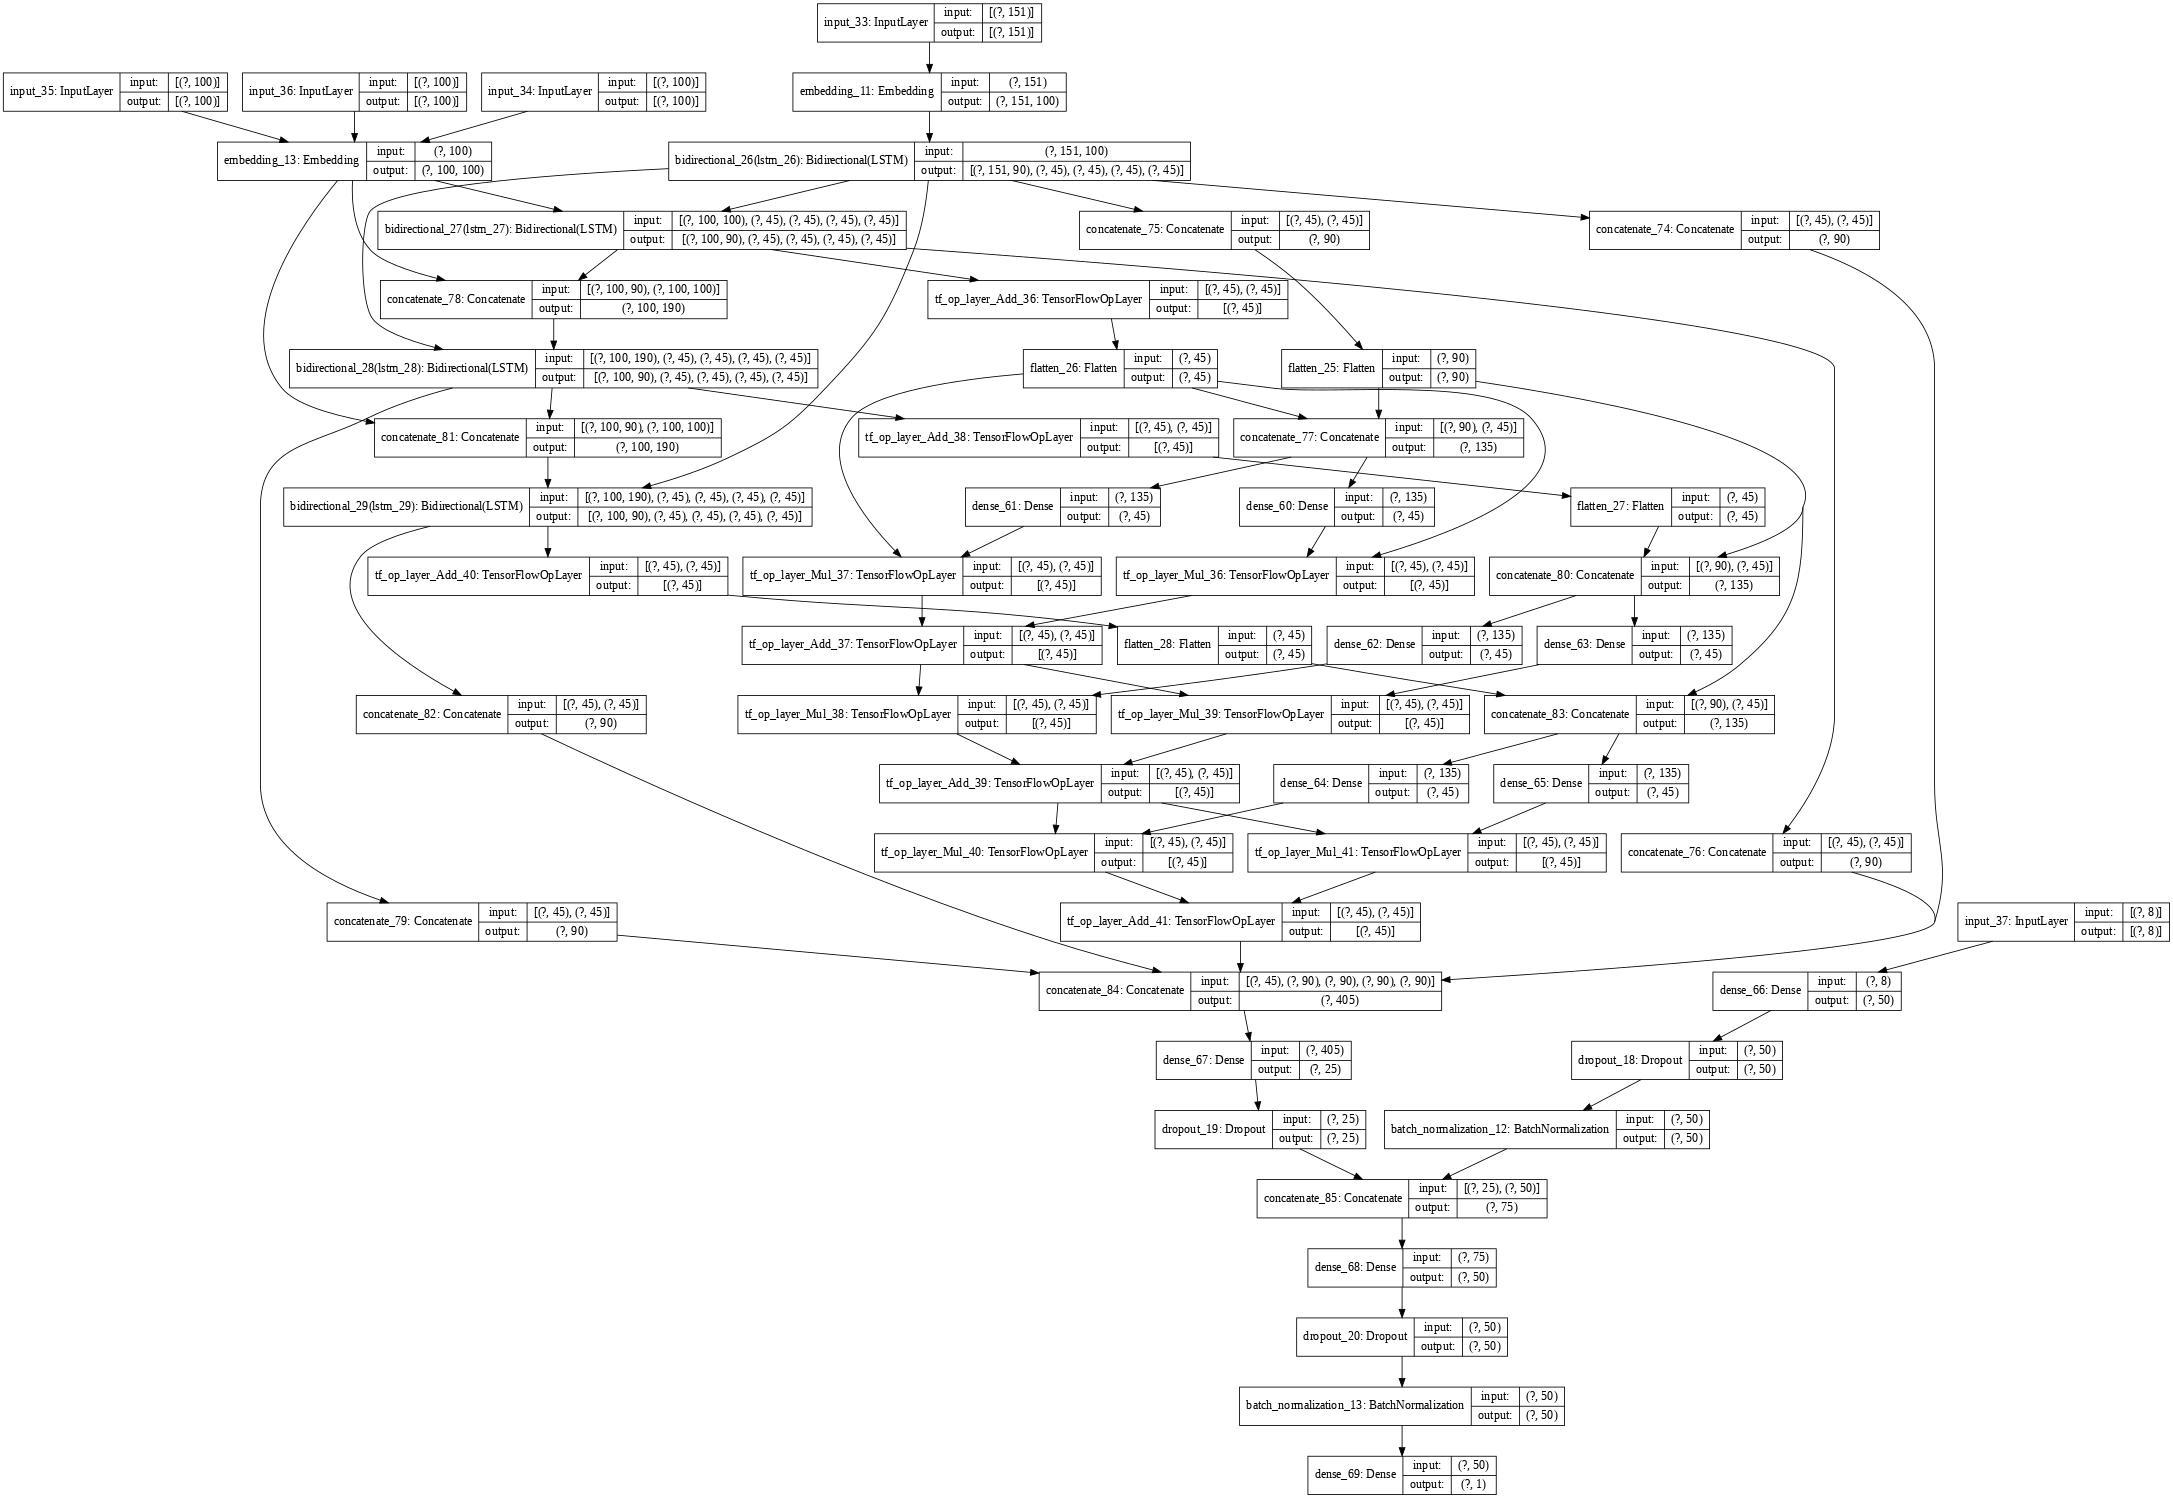

In [83]:
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
model = nn_model_7(45, 50, 45, 45, 25, length1, length, length3, metrics, embedding_motion, embedding_utt)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model8.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')
plot_model(model, to_file='model8.png', show_shapes=True, dpi=60)  

In [84]:
history = model.fit([Xtrain1, utt1_train, utt2_train, utt3_train, Xtrain3.toarray()], y_train, epochs=125, batch_size=470, validation_data=([Xval1, utt1_val, utt2_val, utt3_val, Xval3.toarray()], y_val), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)

Train on 2195 samples, validate on 244 samples
Epoch 1/125
2195/2195 [==============================] - 32s 15ms/sample - loss: 0.9333 - accuracy: 0.4916 - precision: 0.4860 - recall: 0.4807 - auc: 0.4945 - val_loss: 0.7271 - val_accuracy: 0.5492 - val_precision: 0.5377 - val_recall: 0.8560 - val_auc: 0.4967
Epoch 2/125
2195/2195 [==============================] - 17s 8ms/sample - loss: 0.9200 - accuracy: 0.4979 - precision: 0.4928 - recall: 0.5009 - auc: 0.4910 - val_loss: 0.7342 - val_accuracy: 0.5246 - val_precision: 0.5202 - val_recall: 0.9280 - val_auc: 0.4738
Epoch 3/125
2195/2195 [==============================] - 17s 8ms/sample - loss: 0.8929 - accuracy: 0.4870 - precision: 0.4819 - recall: 0.4917 - auc: 0.4906 - val_loss: 0.7311 - val_accuracy: 0.5246 - val_precision: 0.5197 - val_recall: 0.9520 - val_auc: 0.4588
Epoch 4/125
2195/2195 [==============================] - 17s 8ms/sample - loss: 0.8637 - accuracy: 0.5166 - precision: 0.5114 - recall: 0.5157 - auc: 0.5208 - val_los

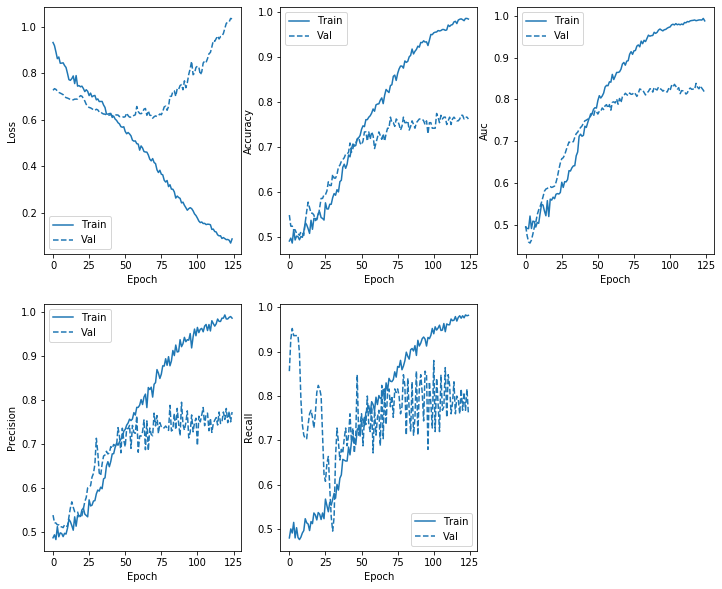

In [85]:
plot_metrics(history)

In [86]:
# Evaluate the accuracy of the best model on test set
model.load_weights("best_model8.hdf5")
results = model.evaluate([Xtest1, utt1_test, utt2_test, utt3_test, Xtest3.toarray()], y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.6572624655330882
accuracy :  0.8492647
precision :  0.8466667
recall :  0.87586206
auc :  0.89554715



**Utterance level BI-LSTM with TF-IDF features**

In [0]:
# transform utterance text
tfidf_speech = tfidf_vectorizer_speech.fit_transform(x_train['cleaned_speech']) 
tfidf_utt1 = tfidf_vectorizer_speech.transform(x_train['utt1'])
tfidf_utt2 = tfidf_vectorizer_speech.transform(x_train['utt2'])
tfidf_utt3 = tfidf_vectorizer_speech.transform(x_train['utt3']+x_train['utt4']+x_train['utt5'])

tfidf_utt1_val = tfidf_vectorizer_speech.transform(x_val['utt1'])
tfidf_utt2_val = tfidf_vectorizer_speech.transform(x_val['utt2'])
tfidf_utt3_val = tfidf_vectorizer_speech.transform(x_val['utt3']+x_val['utt4']+x_val['utt5'])

tfidf_utt1_test = tfidf_vectorizer_speech.transform(x_test['utt1'])
tfidf_utt2_test = tfidf_vectorizer_speech.transform(x_test['utt2'])
tfidf_utt3_test = tfidf_vectorizer_speech.transform(x_test['utt3']+x_test['utt4']+x_test['utt5'])

tfidf_utt1, tfidf_utt1_val, tfidf_utt1_test = reshape_data(tfidf_utt1, tfidf_utt1_val, tfidf_utt1_test)
tfidf_utt2, tfidf_utt2_val, tfidf_utt2_test = reshape_data(tfidf_utt2, tfidf_utt2_val, tfidf_utt2_test)
tfidf_utt3, tfidf_utt3_val, tfidf_utt3_test = reshape_data(tfidf_utt3, tfidf_utt3_val, tfidf_utt3_test)


In [0]:
# Same model as above but a different input layer
def nn_model_8(gate_units, n_neurons, h1, h2, h3, length1, length, length3, metrics):
  # channel 1
  inputs1 = Input(shape=(1, length1))
  bilstm1 = Bidirectional(LSTM(h1, recurrent_dropout=0.7, return_state=True, return_sequences=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")
  output, forward_h, forward_c, backward_h, backward_c = bilstm1(inputs1)
  
  motion_hidden_state = concatenate([forward_h, backward_h])
  motion_cell_state = concatenate([forward_c, backward_c])
  motion_cell_state = Flatten()(motion_cell_state)
  initial_states = [forward_h, forward_c, backward_h, backward_c]

  # channel 2.A for utt1
  inputs2 = Input(shape=(1, length))
  bilstm2 = Bidirectional(LSTM(h2, recurrent_dropout=0.7, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")
  output2, forward_h2, forward_c2, backward_h2, backward_c2 = bilstm2(inputs2, initial_state=initial_states)

  utt1_hidden_state = concatenate([forward_h2, backward_h2])
  utt1_cell_state = tf.math.add(forward_c2, backward_c2)
  utt1_cell_state = Flatten()(utt1_cell_state)
  
  # Update the sentence outputs by applying gates
  gate_in = concatenate([motion_cell_state, utt1_cell_state])  
  fout = Dense(gate_units, activation = "sigmoid")(gate_in)
  uout = Dense(gate_units, activation = "tanh")(gate_in)
  out = tf.math.add(tf.math.multiply(fout, utt1_cell_state), tf.math.multiply(uout, utt1_cell_state))

  # channel 2.B for utt2
  inputs3 = Input(shape=(1, length))
  comb_in1 = concatenate([output2, inputs3])
  bilstm3 = Bidirectional(LSTM(h2, recurrent_dropout=0.7, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")
  output3, forward_h3, forward_c3, backward_h3, backward_c3 = bilstm3(comb_in1, initial_state=initial_states)
 
  utt2_hidden_state = concatenate([forward_h3, backward_h3])
  utt2_cell_state = tf.math.add(forward_c3, backward_c3)
  utt2_cell_state = Flatten()(utt2_cell_state)

  # Update the sentence outputs by applying gates
  gate_in = concatenate([motion_cell_state, utt2_cell_state])  
  fout = Dense(gate_units, activation = "sigmoid")(gate_in)
  uout = Dense(gate_units, activation = "tanh")(gate_in)
  out = tf.math.add(tf.math.multiply(fout, out), tf.math.multiply(uout, out))

  # channel 2.C for utt3 + utt4 + utt5
  inputs4 = Input(shape=(1, length))
  comb_in2 = concatenate([output3, inputs4])
  bilstm4 = Bidirectional(LSTM(h2, recurrent_dropout=0.7, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform'), merge_mode="concat")
  output4, forward_h4, forward_c4, backward_h4, backward_c4 = bilstm4(comb_in2, initial_state=initial_states)
    
  utt3_hidden_state = concatenate([forward_h4, backward_h4])
  utt3_cell_state = tf.math.add(forward_c4, backward_c4)
  utt3_cell_state = Flatten()(utt3_cell_state)

  # Update the sentence outputs by applying gates
  gate_in = concatenate([motion_cell_state, utt3_cell_state])  
  fout = Dense(gate_units, activation = "sigmoid")(gate_in)
  uout = Dense(gate_units, activation = "tanh")(gate_in)
  out = tf.math.add(tf.math.multiply(fout, out), tf.math.multiply(uout, out))

  # channel 5 
  inputs5 = Input(shape=(length3,))
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs5)
  drop3 = Dropout(rate=0.7)(dense3)
  bn3 = BatchNormalization()(drop3)

  merged = concatenate([out, motion_hidden_state, utt1_hidden_state, utt2_hidden_state, utt3_hidden_state])
  dense4 = Dense(h3, activation='tanh', kernel_initializer="he_normal")(merged)
  drop4 = Dropout(rate=0.7)(dense4)

  # merge
  merged2 = concatenate([drop4, bn3])

  # shared
  dense5 = Dense(n_neurons, activation='tanh', kernel_initializer="he_normal")(merged2)
  drop5 = Dropout(rate=0.7)(dense5)
  bn4 = BatchNormalization()(drop5)
  outputs = Dense(1, activation='sigmoid')(bn4)
  model = Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam', clipvalue=1, metrics=metrics)
  return model

In [69]:
model = nn_model_8(7, 15, 7, 7, 15, tfidf_motion.shape[2], tfidf_utt1.shape[2], length3, metrics)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model9.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35, verbose=0, mode='min')
history = model.fit([tfidf_motion, tfidf_utt1, tfidf_utt2, tfidf_utt3, Xtrain3.toarray()], ytrain, epochs=40, batch_size=520, validation_data=([tfidf_motion_val, tfidf_utt1_val, tfidf_utt2_val, tfidf_utt3_val, Xval3.toarray()], yval), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)


Train on 2195 samples, validate on 244 samples
Epoch 1/40
2195/2195 [==============================] - 14s 6ms/sample - loss: 0.8481 - accuracy: 0.4993 - precision: 0.5053 - recall: 0.5531 - auc: 0.4970 - val_loss: 0.7296 - val_accuracy: 0.5000 - val_precision: 0.2857 - val_recall: 0.0168 - val_auc: 0.4883
Epoch 2/40
2195/2195 [==============================] - 1s 535us/sample - loss: 0.8478 - accuracy: 0.5034 - precision: 0.5094 - recall: 0.5378 - auc: 0.5038 - val_loss: 0.7156 - val_accuracy: 0.5000 - val_precision: 0.3333 - val_recall: 0.0252 - val_auc: 0.5130
Epoch 3/40
2195/2195 [==============================] - 1s 496us/sample - loss: 0.8171 - accuracy: 0.5021 - precision: 0.5078 - recall: 0.5540 - auc: 0.5095 - val_loss: 0.7046 - val_accuracy: 0.5123 - val_precision: 0.5000 - val_recall: 0.0420 - val_auc: 0.5535
Epoch 4/40
2195/2195 [==============================] - 1s 484us/sample - loss: 0.7968 - accuracy: 0.5262 - precision: 0.5307 - recall: 0.5594 - auc: 0.5357 - val_loss:

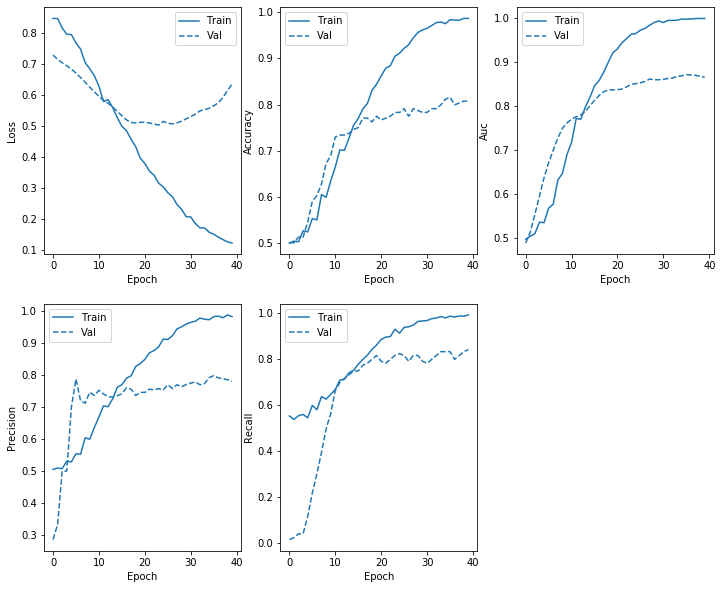

In [70]:
plot_metrics(history)

In [71]:
# Evaluate the accuracy of the best model on test set
model.load_weights("best_model9.hdf5")
results = model.evaluate([tfidf_motion_test, tfidf_utt1_test, tfidf_utt2_test, tfidf_utt3_test, Xtest3.toarray()], y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.6610261096673853
accuracy :  0.7757353
precision :  0.73880595
recall :  0.792
auc :  0.84552383



#**Conclusions**
Please refer the below table for a summary of different trained models with their scores

In [78]:
score = pd.DataFrame({'Models':['SVM', 'SVM', 'NN with one hidden layer', 'Multi-Channel NN with LSTM', 'Multi-Channel NN with LSTM'], 'Text Features': ['BOW', 'TF-IDF', 'TF-IDF', 'TF-IDF', 'Pretrained Glove Embedding']
 ,'F1-Score': [0.75, 0.77, 0.78, 0.75, 0.73], 'ROC-AUC-Score':[0.70, 0.72, 0.71, 0.76, 0.75]})
score

,Models,Text Features,F1-Score,AUC-Score
0,SVM,BOW,0.75,0.70
1,SVM,TF-IDF,0.77,0.72
2,NN with one hidden layer,TF-IDF,0.78,0.71
3,Multi-Channel NN with LSTM,TF-IDF,0.75,0.76
4,Multi-Channel NN with LSTM,Pretrained Glove Embedding,0.73,0.75


After Data Augmentation

In [91]:
acc = [0.7941, 0.7867, 0.6691, 0.7941, 0.7721, 0.7757, 0.7757, 0.8492]
f1score = [0.7812, 0.7957, 0.6281, 0.7777, 0.7559, 0.7645, 0.7645, 0.8610]
auc = [0.8794, 0.8685, 0.7793, 0.8785, 0.8258, 0.8489, 0.8455 , 0.8955]
Model = ['Multi-Channel NN with LSTM', 'Multi-Channel NN with LSTM', 'Multi-Channel NN with LSTM', 'Multi-Channel NN with CNN+LSTM', 'BI-LSTM', 'BI-LSTM', 'Utterance level BI-LSTM', 'Utterance level BI-LSTM']
text_features = ['TF-IDF', 'Pretrained Glove Embedding', 'Trained Embedding', 'Pretrained Glove Embedding', 'TF-IDF', 'Pretrained Glove Embedding', 'TF-IDF', 'Pretrained Glove Embedding']

score = pd.DataFrame({'Models':Model, 'Text Features':text_features, 'Accuracy': acc, 'F1-Score': f1score, 'ROC-AUC-score': auc})
score

,Models,Text Features,Accuracy,F1-Score,AUC-score
0,Multi-Channel NN with LSTM,TF-IDF,0.7941,0.7812,0.8794
1,Multi-Channel NN with LSTM,Pretrained Glove Embedding,0.7867,0.7957,0.8685
2,Multi-Channel NN with LSTM,Trained Embedding,0.6691,0.6281,0.7793
3,Multi-Channel NN with CNN+LSTM,Pretrained Glove Embedding,0.7941,0.7777,0.8785
4,BI-LSTM,TF-IDF,0.7721,0.7559,0.8258
5,BI-LSTM,Pretrained Glove Embedding,0.7757,0.7645,0.8489
6,Utterance level BI-LSTM,TF-IDF,0.7757,0.7645,0.8455
7,Utterance level BI-LSTM,Pretrained Glove Embedding,0.8492,0.8610,0.8955


**Observations**<br/>
Before data augmentation, we have 1251 total data points and imbalanced classes
1. Neural Network with one hidden layer gives similar performance to a SVM
2. Using an LSTM, improves the AUC score 

After data augmentation, we have 2711 total datapoints and balanced classes
1. Overall, using more data improves the scores. The AUC scores are higher for all the models
2. Since we have balanced classes, we can consider the 'Accuracy' metrics. The novel model which uses utterance-level BI-LSTM provides the best accuracy of about 85%. 
3. The multi-channel model with LSTM gave a higher accuracy with TF-IDF features compared to Glove Embeddings. One reason for this can be due to the bi-grams/tri-grams considered for tfidf features. Thus, we tried combining LSTM with CNNs to extract n-grams from embeddings and found a better accuracy.

Overfitting
1. We tuned the models for different hyper-paramter values but there was not a significant improvement in the accuracy.
2. This is because our dataset size is small compared to the number of trainable parameters and as the model gets complex, it starts to overfit.
3. For example, training our own embedding layer gives a very low accuracy because in addition to weights, we have to also train an embedding matrix for the model which increases the parameters.
4. We found that using a CNN with LSTM for embeddings gives approximately same accuracy as the model with only an LSTM and tfidf features whereas BI-LSTMs do not provide significant improvement when we provide complete Speech text.
5. Although complex, utterance level model does show higher accuracy. Providing the input as sentence-by-sentence along with motion latent features instead of combined text is able to better learn the speech representations conditioned on motion features.
6. Having more training data can alleviate overfitting and improve the accuracy of our model. Data Augmentation using word embeddings does not provide completely representative examples since using word embeddings with highest similary ignores the context. So, we also decided to augment the data using speech generation. 
7. Training speech models on existing party speeches to generate new data can provide more representative utterances as it will have same wordings.